In [ ]:
import tensorflow as tf
print(tf.__version__)

# CARGA DE DATOS || OJO VENTANAS..

In [3]:
def cargar_datos_especificos_nuevo2(archivo_potencias='potencia.csv', dias_semanales=None, horas=None, umbral_minimo_considerar_dia = 19.0):
    try:
        import pandas as pd
        import numpy as np
        import logging

        # --- Leer CSV ---
        df = pd.read_csv("potencia2.csv", sep=",")
        original_index = df.index.copy()

        # --- Convertir tiempo a datetime naive en GMT-3 ---
        ###VERIFICADO TENGO QUE PONER ZONA HORARIA, ESTA +0 UTC
        df['Time'] = pd.to_datetime(df['Time'], unit='ms')        # Milisegundos a datetime
        df['Time'] = df['Time'].dt.tz_localize('UTC')             # Marcar como UTC
        df['Time'] = df['Time'].dt.tz_convert('Etc/GMT+3')        # Convertir a GMT-3
        df['Time'] = df['Time'].dt.tz_localize(None)              # Quitar info de zona horaria

        #print(df.columns)
        # ----------------- ACA ELIJO EL MAX
        df = (
            df.groupby(df['Time'].dt.floor('h'))['P1']
            .mean()
            .reset_index()
            .rename(columns={'Time': 'Time'})
        )
        df['Time'] = df['Time'].dt.floor('h')

        # Filtrar días con más de 12 muestras por día directamente
        df = df[df.groupby(df['Time'].dt.date)['Time'].transform('count') > 12]

    
        # --- Filtrar días lunes a viernes según umbral ---
        umbral = umbral_minimo_considerar_dia
        df['weekday'] = df['Time'].dt.weekday
        
        df_lunes_a_viernes = df[df['weekday'] < 5] #5 de lunes a
        max_por_dia = df_lunes_a_viernes.groupby(df_lunes_a_viernes['Time'].dt.date)['P1'].max()
        dias_validos = max_por_dia[max_por_dia > umbral].index

        df = df[(df['weekday'] >= 5) | (df['Time'].dt.date.isin(dias_validos))]
        df.drop(columns=['weekday'], inplace=True)

        # --- Filtrar por días de la semana y horas si corresponde ---
        if dias_semanales is not None:
            df = df[df['Time'].dt.dayofweek.isin(dias_semanales)]
        if horas is not None:
            df = df[df['Time'].dt.hour.isin(horas)]

        # Aseguramos que el índice sea Time
        #df.set_index('Time', inplace=True)

        
        
        df.set_index('Time', inplace=True)



        # --- Quitar rangos de fechas específicos ---
        rangos_a_eliminar = [
            ("2022-07-18", "2022-07-29"),
            ("2023-01-01", "2023-02-28"),
            ("2023-07-17", "2023-07-28"),
            ("2024-07-15", "2024-07-26"),
            ("2024-01-01", "2024-02-29"),
            ("2025-07-21", "2025-08-01"),
            ("2025-01-01", "2025-02-28")
        ]
        for inicio, fin in rangos_a_eliminar:
            df = df.drop(df.loc[inicio:fin].index)

        # Si querés volver a tener Time como columna:
        df.reset_index(inplace=True)
        print("las columnas son", df.columns)

        #df = df.reset_index().set_index(original_index)

        # --- Características temporales cíclicas ---
        df['tiempo_del_dia'] = df['Time'].dt.hour + df['Time'].dt.minute / 60.0
        df['dia_sen'] = np.sin(2 * np.pi * df['tiempo_del_dia'] / 24)
        df['dia_cos'] = np.cos(2 * np.pi * df['tiempo_del_dia'] / 24)

        dias_en_el_anio = df['Time'].dt.is_leap_year.map(lambda x: 366 if x else 365)
        df['dia_del_año'] = df['Time'].dt.dayofyear
        df['mes_sen'] = np.sin(2 * np.pi * df['dia_del_año'] / dias_en_el_anio)
        df['mes_cos'] = np.cos(2 * np.pi * df['dia_del_año'] / dias_en_el_anio)

        # --- Diferencias y picos ---
        df['diferencia_activa'] = df['P1'].diff()
        df['pico'] = (np.abs(df['diferencia_activa']) > 3).astype(int)

        # --- Columnas dummy para días de la semana ---
        for i, dia in enumerate(['lunes','martes','miercoles','jueves','viernes','sabado','domingo']):
            df[dia] = (df['Time'].dt.dayofweek == i).astype(int)

        df['dia_habil'] = df['Time'].dt.dayofweek < 5  # True si lunes-viernes
        df['dia_habil'] = df['dia_habil'].astype(int)

        # --- Reorganizar columnas ---
        final_df = df[['P1','dia_sen','dia_cos','mes_sen','mes_cos','pico','Time',
                    'lunes','martes','miercoles','jueves','viernes','sabado','domingo','dia_habil']]

        # --- Comprobar NaN o infinitos ---
        if np.any(np.isnan(final_df)):
            print("Hay valores NaN en los datos.")
        if np.any(np.isinf(final_df)):
            print("Hay valores infinitos en los datos.")

        # --- Indexar por Time ---
        final_df.set_index('Time', inplace=True)

        print(final_df)
        return final_df

    except Exception as e:
        logging.error(f'Error al cargar los datos: {e}')
        raise



In [4]:
import numpy as np

def crear_ventana_nuevo(dataset, ventana_entrada, ventana_salida, mediciones_previas):
    print("el dataset es", dataset.shape)
    # Agregar las columnas t-1, t-2, t-3, t-4 al DataFrame
    for i in range(0, mediciones_previas):  # Empieza desde 1 hasta ventana_entrada (incluye 8 si ventana_entrada = 8)
        dataset[f'P1-{i}'] = dataset['P1'].shift(i)

    # Eliminar las filas con valores nulos causados por el desplazamiento
    dataset = dataset.dropna()


    # Extraer las características necesarias (t-4, t-3, t-2, t-1 y t)
    columnas_necesarias = [f'P1-{i}' for i in range(0,mediciones_previas)] + ['pico'] + ['dia_sen'] + ['dia_cos'] + ['mes_sen'] + ['mes_cos'] #+ ['dia_habil']#+ ['lunes'] + ['martes'] + ['miercoles']+['jueves']+['viernes']+['sabado']+['domingo']#+['P1'] #+ ['dia_habil'] 

    #columnas_necesarias = [f'activa_t-{i}' for i in range(0,mediciones_previas)] + ['pico'] + ['dia_sen'] + ['dia_cos'] + ['mes_sen'] + ['mes_cos'] +['l1'] +['l2'] + ['l3']
    #columnas_necesarias = [f'activa_t-{i}' for i in range(0,mediciones_previas)] + ['pico'] +['l1'] +['l2'] + ['l3']

    # Incluir las columnas necesarias en el DataFrame
    features = dataset[columnas_necesarias].values

    # Calcular el número total de ventanas que se pueden crear
    total_muestras = len(dataset) - ventana_entrada - ventana_salida + 1

    # Ventanas de entrada (características de t-4, t-3, t-2, t-1 y t)
    X = np.array([features[i:i + ventana_entrada] for i in range(total_muestras)])

    # Ventanas de salida (valor futuro de la potencia activa)
    y = np.array([dataset['P1'].values[i+ventana_entrada :i+ventana_entrada + ventana_salida] for i in range(total_muestras)])
    #y = np.array([dataset['activa'].values[i + ventana_entrada : i + ventana_entrada + ventana_salida] for i in range(total_muestras)])
    #y = y.reshape(-1, ventana_entrada-1, ventana_salida)
    #y = np.array([dataset['activa'].values[i + ventana_entrada-1] for i in range(total_muestras)])
    #y = y.reshape(-1,1)

    return X, y

In [5]:
import numpy as np
import pandas as pd

def crear_ventana_nuevo_dft(df, ventana_entrada, ventana_salida, mediciones_previas, n_frec=6):
    dataset = df.copy()
    
    # Crear columnas de mediciones previas (shift)
    for i in range(mediciones_previas):
        dataset[f'P1-{i}'] = dataset['P1'].shift(i)

    dataset = dataset.dropna()

    columnas_necesarias = [f'P1-{i}' for i in range(mediciones_previas)] + \
                          ['pico','dia_sen','dia_cos','mes_sen','mes_cos','dia_habil']
    
    features = dataset[columnas_necesarias].values

    total_muestras = len(dataset) - ventana_entrada - ventana_salida + 1

    X_list = []
    y_list = []

    for i in range(total_muestras):
        # Ventana de entrada
        x_window = features[i:i + ventana_entrada]

        # Calcular DFT de P1 de la ventana
        p1_window = dataset['P1'].values[i:i+ventana_entrada]
        p1_dft = np.fft.fft(p1_window)
        p1_dft_real = np.real(p1_dft[:n_frec])

        # Repetir las primeras n_frec frecuencias para cada timestep
        dft_col = np.tile(p1_dft_real, (ventana_entrada, 1))

        # Concatenar DFT a la ventana
        x_window_dft = np.hstack([x_window, dft_col])
        X_list.append(x_window_dft)

        # Ventana de salida
        y_window = dataset['P1'].values[i+ventana_entrada : i+ventana_entrada + ventana_salida]
        y_list.append(y_window)

    X = np.array(X_list)
    y = np.array(y_list)
    return X, y


In [6]:
import numpy as np
import pandas as pd

def crear_ventana_nuevo2(dataset, ventana_entrada, ventana_salida, mediciones_previas):
    print("el dataset es", dataset.shape)
    
    # Crear columnas t-1, t-2, ..., t-(mediciones_previas-1)
    for i in range(mediciones_previas):
        dataset[f'P1-{i}'] = dataset['P1'].shift(i)

    # Eliminar filas con NaN
    dataset = dataset.dropna()

    # Columnas que queremos usar como features
    columnas_necesarias = (
        [f'P1-{i}' for i in range(mediciones_previas)] 
        + ['pico','dia_sen','dia_cos','mes_sen','mes_cos' 
           ,'lunes','martes','miercoles','jueves','viernes','sabado','domingo']
    )

    features = dataset[columnas_necesarias].values
    total_muestras = len(dataset) - ventana_entrada - ventana_salida + 1

    X = []
    for i in range(total_muestras):
        ventana = features[i:i+ventana_entrada]  # (ventana_entrada, n_features)
        
        # Rolling mean y std sobre la primera columna (P1-0) de la ventana
        # Convertimos a DataFrame temporal para usar rolling
        df_ventana = pd.DataFrame(ventana[:,0], columns=['P1'])
        roll_mean = df_ventana['P1'].rolling(window=4, min_periods=1).mean().values
        roll_std  = df_ventana['P1'].rolling(window=4, min_periods=2).std().bfill().values


        #### Añadir estas columnas a la ventana
        ventana_ext = np.hstack([ventana, roll_mean.reshape(-1,1), roll_std.reshape(-1,1)])
        X.append(ventana_ext)
        #X.append(ventana)

    X = np.array(X)

    # Ventanas de salida
    y = np.array([dataset['P1'].values[i+ventana_entrada : i+ventana_entrada + ventana_salida] 
                  for i in range(total_muestras)])

    return X, y


# MAIN Y VARIABLES

In [250]:

from red_principal import *  # para usar y guardar
from sklearn.preprocessing import StandardScaler

COMENTARIO = "media todos los dias, modelo 256"
BATCH_SIZE = 16
EPOCAS = 300
PACIENCIA_EARLY = 10

PICO_CONSIDERABLE = 3
UMBRAL_CONSIDERACION_DIA = 13
MEZCLA_TRAIN = 1

if __name__ == "__main__":
    nombre_modelo = "modelo probando4lstm"
    #modificado cargar_datos_especificos, crear_ventana, M solo mediciones

    # Procesamiento de los datos
    dias = [0,1,2,3,4,5,6]  # 0 luneS CON LA ULTIMA MOD
    #dias = [1]  # 0 domingo
    horas = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]  # Ejemplo de horas
    #horas = [8,9,10,11,12,13,14,15,16,17,18,19,20]  # Ejemplo de horas

    df = cargar_datos_especificos_nuevo2('potencia.csv', dias_semanales=dias, horas=horas, umbral_minimo_considerar_dia=UMBRAL_CONSIDERACION_DIA)
    df = df.drop(df.loc["2022-12-7":"2023-3-12"].index)
    df = df.drop(df.loc["2023-12-7":"2024-3-12"].index)
    df = df.drop(df.loc["2024-12-7":"2025-3-12"].index)
    #df = df.drop(df.loc["2022-2-7":"2024-2-20"].index)

    #df = df[df['dia_habil'] == 1] ###me quedo con dias habiles


    print(df.columns)
    #df = df.iloc[::2]
    df['diferencia_activa'] = df['P1'].diff()
    df['pico'] = np.where(np.abs(df['diferencia_activa']) > PICO_CONSIDERABLE, 1, 0)
    df['pico_2'] = np.where(np.abs(df['diferencia_activa']) > PICO_CONSIDERABLE*2, 1, 0)
    print("tengo estos datos ",df.shape)
    print("el df queda quedando")
    print(df)

    
    

    ventana_entrada = 24
    mediciones_previas = 1
    ventana_salida = 24

    X, y = crear_ventana_nuevo(df, ventana_entrada, ventana_salida, mediciones_previas)

    print("crear ventana genero ",X.shape)
   
    ####### SEPARACION DE DATOS
    inicio_train = 0#3
    fin_train = 10000 #6500
    FECHA_INICIO_TRAIN = df.index[inicio_train]
    FECHA_FIN_TRAIN = df.index[fin_train]
    
    
    #fin_train = 500

    inicio_val = fin_train+1
    #fin_val = fin_train+1+100
    fin_val = fin_train+1+2000#1250
    FECHA_INICIO_VAL = df.index[inicio_val]
    FECHA_FIN_VAL = df.index[fin_val]

    inicio_test = fin_val+1
    #fin_test = inicio_test+1+100
    fin_test = inicio_test+1+2200#1250
    FECHA_INICIO_TEST = df.index[inicio_test]
    FECHA_FIN_TEST = df.index[fin_test]


    # conjunto de validación
    Xval = X[inicio_val:fin_val]
    yval = y[inicio_val:fin_val]
    #conjunto de entrenamiento
    Xtrain = X[inicio_train:fin_train]
    ytrain = y[inicio_train:fin_train]
    # conjunto de validación
    Xtest = X[inicio_test:fin_test]
    ytest = y[inicio_test:fin_test]

    


    # Ejemplo: ytest es una columna o un DataFrame de una sola columna
    # Calculamos la diferencia con el valor anterior
    diferencias = np.abs(np.diff(ytest, axis=0))  # axis=0 → diferencias fila a fila

    # Contar cuántas diferencias superan PICO_CONSIDERABLE
    cantidad_picos = np.sum(diferencias > PICO_CONSIDERABLE)

    print("Cantidad de picos en ytest:", cantidad_picos)


    from sklearn.utils import shuffle

    # Mezclar Xtrain y ytrain
    if MEZCLA_TRAIN == 1:
        Xtrain, ytrain = shuffle(Xtrain, ytrain, random_state=42)



    #print("el dato 0 tiene", Xtrain[0], "shape", Xtrain.shape)
    #print("el y0 tiene:", ytrain[0], "shape", ytrain.shape)

    #print("el dato 1 tiene", Xtrain[1], "shape", Xtrain.shape)
    #print("el y1 tiene:", ytrain[1], "shape", ytrain.shape)

    #print("los que me interesa ver son",ytrain[:,ventana_entrada-1] )
    #SCALERS
    print("el shape train es", Xtrain.shape)
    print("el shape val es", Xval.shape)
    scaleractiva = StandardScaler()
    scalermedia = StandardScaler()
    scalerestandar = StandardScaler()
    scalerdiferencias = StandardScaler()


    Xtrain_n = Xtrain.copy()
    feature_suavizado = 13
    feature_estandar = 14
    feature_diferencias = 2
    Xtrain_n[:, :, 0] = scaleractiva.fit_transform(Xtrain[:, :, 0])
    #Xtrain_n[:, :, feature_suavizado] = scalermedia.fit_transform(Xtrain[:, :, feature_suavizado])
    #Xtrain_n[:, :, feature_estandar] = scalerestandar.fit_transform(Xtrain[:, :, feature_estandar])
    Xtrain_n[:, :, feature_diferencias] = scalerdiferencias.fit_transform(Xtrain[:, :, feature_diferencias])

    scalercorriente = StandardScaler()
    #Xtrain_n[:, :, 6] = scalercorriente.fit_transform(Xtrain[:, :, 6])

    for i in range(1,mediciones_previas):
        Xtrain_n[:, :, i] = scaleractiva.transform(Xtrain[:, :, i])


    Xval_n = Xval.copy()
    for i in range(mediciones_previas):
        Xval_n[:, :, i] = scaleractiva.transform(Xval[:, :, i])
    #Xval_n[:, :, feature_suavizado] = scalermedia.transform(Xval[:, :, feature_suavizado])
    #Xval_n[:, :, feature_estandar] = scalerestandar.transform(Xval[:, :, feature_estandar])
    Xval_n[:, :, feature_diferencias] = scalerdiferencias.transform(Xval[:, :, feature_diferencias])



    Xtest_n = Xtest.copy()
    for i in range(mediciones_previas):
        Xtest_n[:, :, i] = scaleractiva.transform(Xtest[:, :, i])
    #Xtest_n[:, :, feature_suavizado] = scalermedia.transform(Xtest[:, :, feature_suavizado])
    #Xtest_n[:, :, feature_estandar] = scalerestandar.transform(Xtest[:, :, feature_estandar])
    Xtest_n[:, :, feature_diferencias] = scalerdiferencias.transform(Xtest[:, :, feature_diferencias])
    #    Xtest_n[:, :, 6] = scalercorriente.transform(Xtest[:, :, 6])





    salidas = StandardScaler()

    ytrain_n = ytrain.copy()
    yval_n = yval.copy()
    ytest_n = ytest.copy()


    print("el shape train es", Xtrain_n.shape)
    print("el shape val es", Xval_n.shape)
    print("el shape train es", ytrain_n.shape)
    print("el shape train es", yval_n.shape)
   

    ytrain_n = salidas.fit_transform(ytrain)
    yval_n = salidas.transform(yval)
    ytest_n = salidas.transform(ytest)


    scalers = {'scaleractiva': scaleractiva, 'salidas': salidas , 'scalerdiferencias': scalerdiferencias}
    print("el shape train es", Xtrain_n.shape)
    print("el shape val es", Xval_n.shape)
    print("el shape train es", ytrain_n.shape)
    print("el shape train es", yval_n.shape)
    print("el shape test es", ytest.shape)
    print("el shape test es", ytest.shape)

    print(Xtrain_n)

las columnas son Index(['Time', 'P1'], dtype='object')
                            P1   dia_sen   dia_cos   mes_sen   mes_cos  pico  \
Time                                                                           
2022-11-09 00:00:00   4.856283  0.000000  1.000000 -0.780296  0.625411     0   
2022-11-09 01:00:00   5.576527  0.258819  0.965926 -0.780296  0.625411     0   
2022-11-09 02:00:00   5.629216  0.500000  0.866025 -0.780296  0.625411     0   
2022-11-09 03:00:00   6.549148  0.707107  0.707107 -0.780296  0.625411     0   
2022-11-09 04:00:00   6.192008  0.866025  0.500000 -0.780296  0.625411     0   
...                        ...       ...       ...       ...       ...   ...   
2025-09-03 19:00:00  11.293554 -0.965926  0.258819 -0.888057 -0.459733     0   
2025-09-03 20:00:00   8.588032 -0.866025  0.500000 -0.888057 -0.459733     0   
2025-09-03 21:00:00   7.021688 -0.707107  0.707107 -0.888057 -0.459733     0   
2025-09-03 22:00:00   6.913840 -0.500000  0.866025 -0.888057 -0.4

In [8]:
df["sabado"].max()

1

In [148]:
df.head

<bound method NDFrame.head of                             P1   dia_sen   dia_cos   mes_sen   mes_cos  pico  \
Time                                                                           
2022-11-09 00:00:00   4.856283  0.000000  1.000000 -0.780296  0.625411     0   
2022-11-09 01:00:00   5.576527  0.258819  0.965926 -0.780296  0.625411     0   
2022-11-09 02:00:00   5.629216  0.500000  0.866025 -0.780296  0.625411     0   
2022-11-09 03:00:00   6.549148  0.707107  0.707107 -0.780296  0.625411     0   
2022-11-09 04:00:00   6.192008  0.866025  0.500000 -0.780296  0.625411     0   
...                        ...       ...       ...       ...       ...   ...   
2025-09-03 19:00:00  11.293554 -0.965926  0.258819 -0.888057 -0.459733     0   
2025-09-03 20:00:00   8.588032 -0.866025  0.500000 -0.888057 -0.459733     0   
2025-09-03 21:00:00   7.021688 -0.707107  0.707107 -0.888057 -0.459733     0   
2025-09-03 22:00:00   6.913840 -0.500000  0.866025 -0.888057 -0.459733     0   
2025-09-03

In [149]:
import pandas as pd

dias = ["lunes","martes","miercoles","jueves","viernes","sabado","domingo"]

dfs_filtrados = []

for dia in dias:
    df_dia = df[df[dia] == 1].copy()
    
    # Agrupamos por fecha completa (solo año-mes-día)
    df_dia['fecha'] = df_dia.index.date
    
    # Contamos cuántas horas hay por día
    conteo_por_fecha = df_dia.groupby('fecha').size()
    
    # Solo tomamos fechas que tengan 24 registros
    fechas_completas = conteo_por_fecha[conteo_por_fecha == 24].index
    
    # Filtramos el DataFrame
    dfs_filtrados.append(df_dia[df_dia['fecha'].isin(fechas_completas)])
    
# Concatenamos todo
df_filtrado = pd.concat(dfs_filtrados).sort_index()

# Eliminamos columna auxiliar
df_filtrado = df_filtrado.drop(columns=['fecha'])

# Conteo final por día
conteo_final = {dia: df_filtrado[dia].sum() for dia in dias}
print(conteo_final)


{'lunes': 1848, 'martes': 2064, 'miercoles': 2136, 'jueves': 2040, 'viernes': 1872, 'sabado': 2352, 'domingo': 2256}


In [237]:
dias = ["lunes", "martes", "miercoles", "jueves", "viernes", "sabado", "domingo"]

conteo_dias = {dia: df[dia].sum() for dia in dias}  # suma valores True/1 en cada columna
print(conteo_dias)

{'lunes': 1910, 'martes': 2079, 'miercoles': 2152, 'jueves': 2079, 'viernes': 1936, 'sabado': 2352, 'domingo': 2272}


In [238]:
import pandas as pd
import numpy as np

dias = ["lunes","martes","miercoles","jueves","viernes","sabado","domingo"]

dfs_filtrados = []

for dia in dias:
    df_dia = df[df[dia] == 1].copy()
    
    # Agrupamos por fecha completa (solo año-mes-día)
    df_dia['fecha'] = df_dia.index.date
    
    # Contamos cuántas horas hay por día
    conteo_por_fecha = df_dia.groupby('fecha').size()
    
    # Solo tomamos fechas que tengan 24 registros
    fechas_completas = conteo_por_fecha[conteo_por_fecha == 24].index
    
    # Filtramos el DataFrame
    df_dia = df_dia[df_dia['fecha'].isin(fechas_completas)]
    
    dfs_filtrados.append(df_dia)

# Concatenamos todos los días
df_filtrado = pd.concat(dfs_filtrados).sort_index()

# Calculamos el mínimo número de días completos entre todos los días
min_dias = min(df_filtrado[dia].groupby(df_filtrado.index.date).sum().shape[0] for dia in dias)

# Ahora recortamos al azar cada día para que tenga el mismo número de días completos
dfs_balanceados = []
for dia in dias:
    df_dia = df_filtrado[df_filtrado[dia] == 1].copy()
    fechas_unicas = df_dia.index.date
    fechas_unicas = sorted(list(set(fechas_unicas)))
    
    if len(fechas_unicas) > min_dias:
        # Elegimos al azar min_dias fechas
        fechas_seleccionadas = np.random.choice(fechas_unicas, min_dias, replace=False)
        df_dia = df_dia[df_dia['fecha'].isin(fechas_seleccionadas)]
    
    dfs_balanceados.append(df_dia)

# Concatenamos el dataset final balanceado
df_final = pd.concat(dfs_balanceados).sort_index()
df_final = df_final.drop(columns=['fecha'])

# Conteo final por día
conteo_final = {dia: df_final[dia].sum() for dia in dias}
print(conteo_final)


{'lunes': 1848, 'martes': 2064, 'miercoles': 2136, 'jueves': 2040, 'viernes': 1872, 'sabado': 2352, 'domingo': 2256}


In [240]:
import pandas as pd
import numpy as np

dias = ["lunes","martes","miercoles","jueves","viernes","sabado","domingo"]

# Cantidad objetivo de registros por día
objetivo = 1848

dfs_balanceados = []

for dia in dias:
    df_dia = df[df[dia] == 1].copy()
    
    # Agregar columna auxiliar para fecha completa
    df_dia['fecha'] = df_dia.index.date
    
    # Filtramos solo días completos de 24 horas
    conteo_por_fecha = df_dia.groupby('fecha').size()
    fechas_completas = conteo_por_fecha[conteo_por_fecha == 24].index
    df_dia = df_dia[df_dia['fecha'].isin(fechas_completas)]
    
    # Si hay más filas que el objetivo, eliminamos al azar
    if len(df_dia) > objetivo:
        df_dia = df_dia.sample(n=objetivo, random_state=42)  # random_state para reproducibilidad
    
    dfs_balanceados.append(df_dia)

# Concatenamos todos los días balanceados
df_final = pd.concat(dfs_balanceados).sort_index()

# Eliminamos columna auxiliar
df_final = df_final.drop(columns=['fecha'])

# Conteo final por día
conteo_final = {dia: df_final[dia].sum() for dia in dias}
print(conteo_final)


{'lunes': 1848, 'martes': 1848, 'miercoles': 1848, 'jueves': 1848, 'viernes': 1848, 'sabado': 1848, 'domingo': 1848}


In [209]:
COMENTARIO = "media todos los dias, df balanceado"


In [241]:
    X, y = crear_ventana_nuevo(df_final, ventana_entrada, ventana_salida, mediciones_previas)

    print("crear ventana genero ",X.shape)
   
    ####### SEPARACION DE DATOS
    inicio_train = 0#3
    fin_train = 9000 #6500
    FECHA_INICIO_TRAIN = df.index[inicio_train]
    FECHA_FIN_TRAIN = df.index[fin_train]
    
    
    #fin_train = 500

    inicio_val = fin_train+1
    #fin_val = fin_train+1+100
    fin_val = fin_train+1+2000#1250
    FECHA_INICIO_VAL = df.index[inicio_val]
    FECHA_FIN_VAL = df.index[fin_val]

    inicio_test = fin_val+1
    #fin_test = inicio_test+1+100
    fin_test = inicio_test+1+2200#1250
    FECHA_INICIO_TEST = df.index[inicio_test]
    FECHA_FIN_TEST = df.index[fin_test]


    # conjunto de validación
    Xval = X[inicio_val:fin_val]
    yval = y[inicio_val:fin_val]
    #conjunto de entrenamiento
    Xtrain = X[inicio_train:fin_train]
    ytrain = y[inicio_train:fin_train]
    # conjunto de validación
    Xtest = X[inicio_test:fin_test]
    ytest = y[inicio_test:fin_test]

    


    # Ejemplo: ytest es una columna o un DataFrame de una sola columna
    # Calculamos la diferencia con el valor anterior
    diferencias = np.abs(np.diff(ytest, axis=0))  # axis=0 → diferencias fila a fila

    # Contar cuántas diferencias superan PICO_CONSIDERABLE
    cantidad_picos = np.sum(diferencias > PICO_CONSIDERABLE)

    print("Cantidad de picos en ytest:", cantidad_picos)


    from sklearn.utils import shuffle

    # Mezclar Xtrain y ytrain
    if MEZCLA_TRAIN == 1:
        Xtrain, ytrain = shuffle(Xtrain, ytrain, random_state=42)



    #print("el dato 0 tiene", Xtrain[0], "shape", Xtrain.shape)
    #print("el y0 tiene:", ytrain[0], "shape", ytrain.shape)

    #print("el dato 1 tiene", Xtrain[1], "shape", Xtrain.shape)
    #print("el y1 tiene:", ytrain[1], "shape", ytrain.shape)

    #print("los que me interesa ver son",ytrain[:,ventana_entrada-1] )
    #SCALERS
    print("el shape train es", Xtrain.shape)
    print("el shape val es", Xval.shape)
    scaleractiva = StandardScaler()
    scalermedia = StandardScaler()
    scalerestandar = StandardScaler()
    scalerdiferencias = StandardScaler()


    Xtrain_n = Xtrain.copy()
    feature_suavizado = 13
    feature_estandar = 14
    feature_diferencias = 2
    Xtrain_n[:, :, 0] = scaleractiva.fit_transform(Xtrain[:, :, 0])
    #Xtrain_n[:, :, feature_suavizado] = scalermedia.fit_transform(Xtrain[:, :, feature_suavizado])
    #Xtrain_n[:, :, feature_estandar] = scalerestandar.fit_transform(Xtrain[:, :, feature_estandar])
    Xtrain_n[:, :, feature_diferencias] = scalerdiferencias.fit_transform(Xtrain[:, :, feature_diferencias])

    scalercorriente = StandardScaler()
    #Xtrain_n[:, :, 6] = scalercorriente.fit_transform(Xtrain[:, :, 6])

    for i in range(1,mediciones_previas):
        Xtrain_n[:, :, i] = scaleractiva.transform(Xtrain[:, :, i])


    Xval_n = Xval.copy()
    for i in range(mediciones_previas):
        Xval_n[:, :, i] = scaleractiva.transform(Xval[:, :, i])
    #Xval_n[:, :, feature_suavizado] = scalermedia.transform(Xval[:, :, feature_suavizado])
    #Xval_n[:, :, feature_estandar] = scalerestandar.transform(Xval[:, :, feature_estandar])
    Xval_n[:, :, feature_diferencias] = scalerdiferencias.transform(Xval[:, :, feature_diferencias])



    Xtest_n = Xtest.copy()
    for i in range(mediciones_previas):
        Xtest_n[:, :, i] = scaleractiva.transform(Xtest[:, :, i])
    #Xtest_n[:, :, feature_suavizado] = scalermedia.transform(Xtest[:, :, feature_suavizado])
    #Xtest_n[:, :, feature_estandar] = scalerestandar.transform(Xtest[:, :, feature_estandar])
    Xtest_n[:, :, feature_diferencias] = scalerdiferencias.transform(Xtest[:, :, feature_diferencias])
    #    Xtest_n[:, :, 6] = scalercorriente.transform(Xtest[:, :, 6])





    salidas = StandardScaler()

    ytrain_n = ytrain.copy()
    yval_n = yval.copy()
    ytest_n = ytest.copy()


    print("el shape train es", Xtrain_n.shape)
    print("el shape val es", Xval_n.shape)
    print("el shape train es", ytrain_n.shape)
    print("el shape train es", yval_n.shape)
   

    ytrain_n = salidas.fit_transform(ytrain)
    yval_n = salidas.transform(yval)
    ytest_n = salidas.transform(ytest)


    scalers = {'scaleractiva': scaleractiva, 'salidas': salidas , 'scalerdiferencias': scalerdiferencias}
    print("el shape train es", Xtrain_n.shape)
    print("el shape val es", Xval_n.shape)
    print("el shape train es", ytrain_n.shape)
    print("el shape train es", yval_n.shape)
    print("el shape test es", ytest.shape)
    print("el shape test es", ytest.shape)

    print(Xtrain_n)

el dataset es (12936, 17)
crear ventana genero  (12864, 48, 6)
Cantidad de picos en ytest: 6579
el shape train es (9000, 48, 6)
el shape val es (2000, 48, 6)
el shape train es (9000, 48, 6)
el shape val es (2000, 48, 6)
el shape train es (9000, 24)
el shape train es (2000, 24)
el shape train es (9000, 48, 6)
el shape val es (2000, 48, 6)
el shape train es (9000, 24)
el shape train es (2000, 24)
el shape test es (1862, 24)
el shape test es (1862, 24)
[[[ 2.46550876e+00  1.00000000e+00 -3.68623001e-01 -9.65925826e-01
   -6.85547606e-01 -7.28027801e-01]
  [ 6.94643965e-01  1.00000000e+00 -1.00193521e+00 -7.07106781e-01
   -6.85547606e-01 -7.28027801e-01]
  [ 3.79616728e-01  0.00000000e+00 -1.22645777e+00 -5.00000000e-01
   -6.85547606e-01 -7.28027801e-01]
  ...
  [ 8.02139264e-01  0.00000000e+00 -7.08902586e-01 -8.66025404e-01
   -7.10135016e-01 -7.04065522e-01]
  [ 3.11730068e-01  0.00000000e+00 -1.00149264e+00 -7.07106781e-01
   -7.10135016e-01 -7.04065522e-01]
  [ 6.02741294e-02  0.000

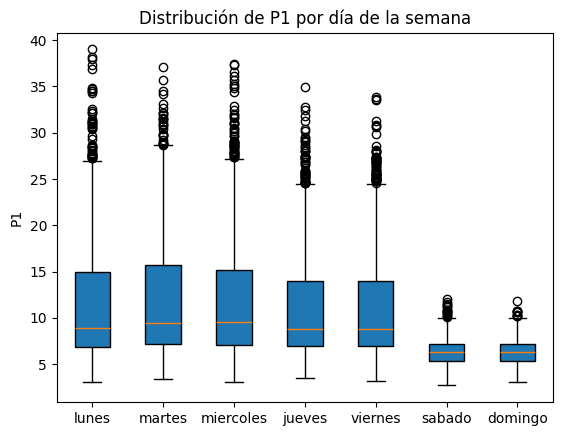

In [206]:
import matplotlib.pyplot as plt

# Lista de subdatasets (ejemplo)
dias = ["lunes", "martes", "miercoles", "jueves", "viernes", "sabado", "domingo"]
subdatasets = [df[df[dia] == 1]["P1"] for dia in dias]

# Generar boxplot
plt.boxplot(subdatasets, labels=dias, vert=True, patch_artist=True)
plt.title("Distribución de P1 por día de la semana")
plt.ylabel("P1")
plt.show()


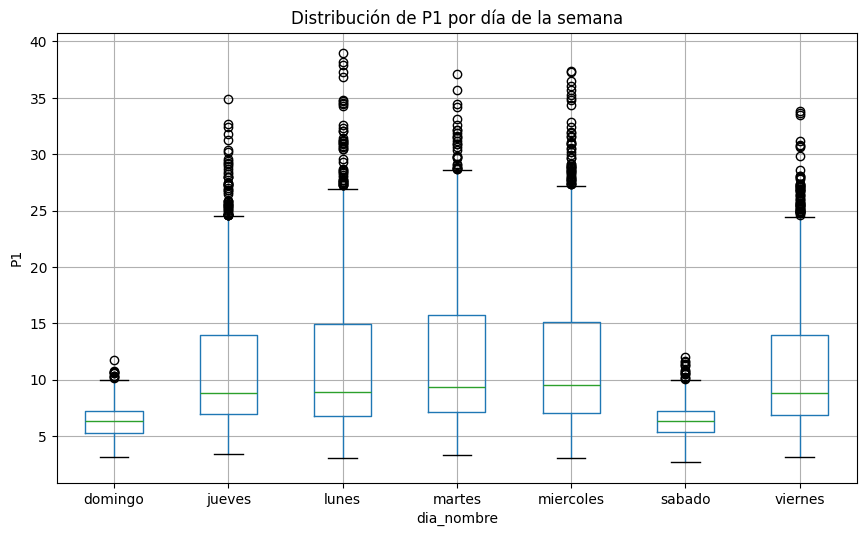

In [207]:
# Supongamos que tenés la columna 'dia' con el nombre del día
df["dia_nombre"] = df[["lunes","martes","miercoles","jueves","viernes","sabado","domingo"]].idxmax(axis=1)

# Boxplot directo desde pandas
df.boxplot(column="P1", by="dia_nombre", figsize=(10,6))
plt.title("Distribución de P1 por día de la semana")
plt.suptitle("")  # para borrar el título automático
plt.ylabel("P1")
plt.show()


In [11]:
import pandas as pd

# Suponemos que df tiene índice datetime y columnas de días one-hot
dias = ["lunes", "martes", "miercoles", "jueves", "viernes", "sabado", "domingo"]

# Crear columna con el nombre del día
df["dia_nombre"] = df[dias].idxmax(axis=1)

# Lista para acumular outliers
outliers_lista = []

for dia in dias:
    # Subdataset del día
    datos = df[df["dia_nombre"] == dia]["P1"]

    # Q1, Q3 e IQR
    Q1 = datos.quantile(0.25)
    Q3 = datos.quantile(0.75)
    IQR = Q3 - Q1

    # Límites
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR

    # Condición de outliers
    condicion = (datos < lim_inf) | (datos > lim_sup)
    outliers = datos[condicion]

    # Guardar en lista con límites
    for idx, valor in outliers.items():
        outliers_lista.append({
            "time": idx,
            "dia": dia,
            "P1": valor,
            "lim_inf": lim_inf,
            "lim_sup": lim_sup,
            "distancia": max(0, valor - lim_sup, lim_inf - valor)
        })

# Convertir a DataFrame final
outliers_df = pd.DataFrame(outliers_lista)

print(outliers_df.head())
print(outliers_df)



                 time    dia         P1   lim_inf   lim_sup  distancia
0 2023-04-17 11:00:00  lunes  27.303980 -5.354188  27.13133   0.172650
1 2023-05-22 11:00:00  lunes  27.348307 -5.354188  27.13133   0.216978
2 2023-05-22 12:00:00  lunes  28.376201 -5.354188  27.13133   1.244871
3 2023-05-22 14:00:00  lunes  29.599662 -5.354188  27.13133   2.468333
4 2023-05-29 11:00:00  lunes  32.334561 -5.354188  27.13133   5.203231
                   time      dia         P1   lim_inf    lim_sup  distancia
0   2023-04-17 11:00:00    lunes  27.303980 -5.354188  27.131330   0.172650
1   2023-05-22 11:00:00    lunes  27.348307 -5.354188  27.131330   0.216978
2   2023-05-22 12:00:00    lunes  28.376201 -5.354188  27.131330   1.244871
3   2023-05-22 14:00:00    lunes  29.599662 -5.354188  27.131330   2.468333
4   2023-05-29 11:00:00    lunes  32.334561 -5.354188  27.131330   5.203231
..                  ...      ...        ...       ...        ...        ...
254 2023-06-18 08:00:00  domingo  10.58380

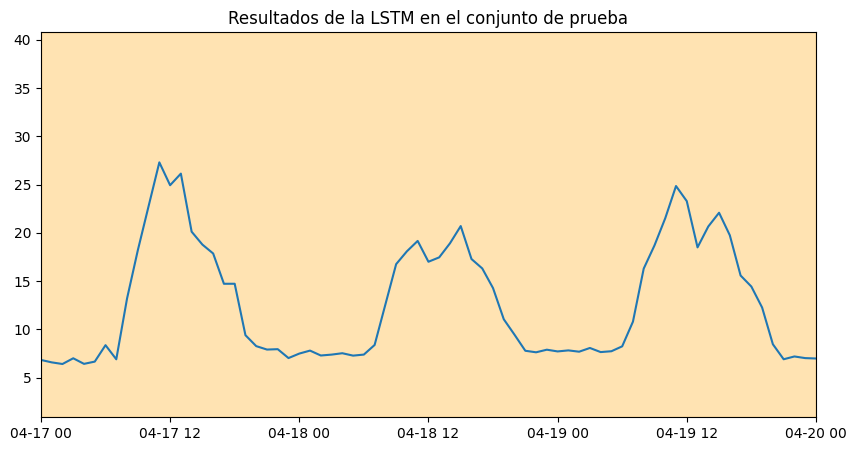

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(df["P1"], label='train')
# Definir rango a resaltar
fecha_inicio = pd.Timestamp('2023-4-17')
fecha_fin    = pd.Timestamp('2023-4-20')
# Limitar el eje X al rango deseado
plt.xlim(fecha_inicio, fecha_fin)

# Resaltar rango
plt.axvspan(fecha_inicio, fecha_fin, color='orange', alpha=0.3, label='Rango seleccionado')

plt.title('Resultados de la LSTM en el conjunto de prueba')
plt.show()

In [13]:
print(Xtrain[0,:,2])

[ 2.58819045e-01  5.00000000e-01  7.07106781e-01  8.66025404e-01
  9.65925826e-01  1.00000000e+00  9.65925826e-01  8.66025404e-01
  7.07106781e-01  5.00000000e-01  2.58819045e-01  1.22464680e-16
 -2.58819045e-01 -5.00000000e-01 -7.07106781e-01 -8.66025404e-01
 -9.65925826e-01 -1.00000000e+00 -9.65925826e-01 -8.66025404e-01
 -7.07106781e-01 -5.00000000e-01 -2.58819045e-01  0.00000000e+00]


In [14]:
print(Xtrain_n[0,:,2])

[ 3.65679731e-01  7.06950351e-01  1.00003662e+00  1.22501357e+00
  1.36656944e+00  1.41503747e+00  1.36706628e+00  1.22587661e+00
  1.00107022e+00  7.07987305e-01  3.66649397e-01  3.66508747e-04
 -3.65879753e-01 -7.07150359e-01 -1.00023665e+00 -1.22521364e+00
 -1.36676958e+00 -1.41523767e+00 -1.36726651e+00 -1.22607686e+00
 -1.00127045e+00 -7.08187493e-01 -3.66849523e-01 -5.66573486e-04]


In [15]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def crear_scalers_dft(X_train, cantidad_componentes):
    """
    Crea scalers para las últimas 'cantidad_componentes' features de X_train.
    """
    num_ventanas, ventana_entrada, num_features = X_train.shape
    inicio_dft = num_features - cantidad_componentes
    
    scalers_dft = [StandardScaler() for _ in range(cantidad_componentes)]
    
    for i, idx in enumerate(range(inicio_dft, num_features)):
        vals = X_train[:, :, idx].reshape(-1, 1)
        scalers_dft[i].fit(vals)
    
    return scalers_dft

def aplicar_scalers_dft(X, scalers_dft):
    """
    Aplica scalers DFT a X. Debe recibir la lista de scalers creada a partir de X_train.
    """
    X_scaled = X.copy()
    num_ventanas, ventana_entrada, num_features = X.shape
    cantidad_componentes = len(scalers_dft)
    inicio_dft = num_features - cantidad_componentes
    
    for i, idx in enumerate(range(inicio_dft, num_features)):
        vals = X[:, :, idx].reshape(-1, 1)
        X_scaled[:, :, idx] = scalers_dft[i].transform(vals).reshape(num_ventanas, ventana_entrada)
    
    return X_scaled



In [16]:
cantidad_componentes = 6

# 1. Crear scalers usando solo el set de entrenamiento
scalers_dft = crear_scalers_dft(Xtrain_n, cantidad_componentes)

# 2. Aplicar transform a entrenamiento y validación
Xtrain_n = aplicar_scalers_dft(Xtrain_n, scalers_dft)
Xval_n   = aplicar_scalers_dft(Xval_n, scalers_dft)
Xtest_n   = aplicar_scalers_dft(Xtest_n, scalers_dft)

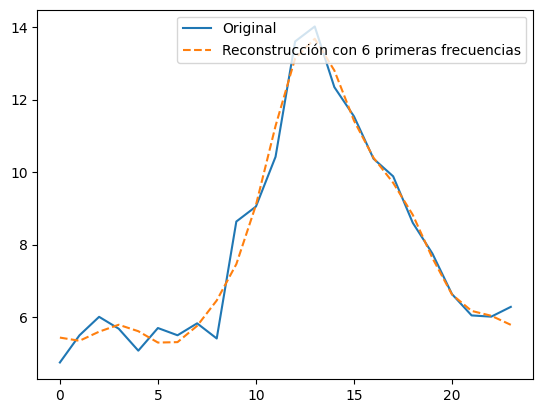

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que X ya contiene las ventanas
# Tomamos la primera ventana y la primera característica (P1)
p1_window = X[334, :, 0]  # shape: (ventana_entrada,)

# Calculamos la DFT
p1_dft = np.fft.fft(p1_window)

# Tomamos las primeras 6 frecuencias (coeficientes complejos)
p1_dft_6 = p1_dft[:6]

# Reconstrucción aproximada usando solo esas 6 frecuencias
# np.fft.ifft requiere la misma longitud que la original, así que llenamos lo demás con ceros
recon_dft = np.zeros_like(p1_dft)
recon_dft[:6] = p1_dft_6
# Para mantener simetría y obtener señal real:
recon_dft[-5:] = np.conj(p1_dft_6[1:][::-1])

p1_recon = np.fft.ifft(recon_dft).real  # reconstrucción aproximada

# Graficamos
plt.plot(p1_window, label="Original")
plt.plot(p1_recon, label="Reconstrucción con 6 primeras frecuencias", linestyle="--")
plt.legend()
plt.show()



In [18]:
df[1800:2000]

,P1,dia_sen,dia_cos,mes_sen,mes_cos,pico,lunes,martes,miercoles,jueves,viernes,sabado,domingo,dia_habil,diferencia_activa,pico_2,P1-0,dia_nombre
Time,,,,,,,,,,,,,,,,,,
2023-05-11 02:00:00,7.271913,0.500000,8.660254e-01,0.774884,-0.632103,0,0,0,0,1,0,0,0,1,-0.812280,0,7.271913,jueves
2023-05-11 03:00:00,8.615200,0.707107,7.071068e-01,0.774884,-0.632103,0,0,0,0,1,0,0,0,1,1.343287,0,8.615200,jueves
2023-05-11 04:00:00,8.768717,0.866025,5.000000e-01,0.774884,-0.632103,0,0,0,0,1,0,0,0,1,0.153517,0,8.768717,jueves
2023-05-11 05:00:00,9.207073,0.965926,2.588190e-01,0.774884,-0.632103,0,0,0,0,1,0,0,0,1,0.438356,0,9.207073,jueves
2023-05-11 06:00:00,9.715332,1.000000,6.123234e-17,0.774884,-0.632103,0,0,0,0,1,0,0,0,1,0.508259,0,9.715332,jueves
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-22 14:00:00,29.599662,-0.500000,-8.660254e-01,0.642055,-0.766659,1,1,0,0,0,0,0,0,1,3.185059,0,29.599662,lunes
2023-05-22 15:00:00,21.500343,-0.707107,-7.071068e-01,0.642055,-0.766659,1,1,0,0,0,0,0,0,1,-8.099319,1,21.500343,lunes
2023-05-22 16:00:00,16.791000,-0.866025,-5.000000e-01,0.642055,-0.766659,1,1,0,0,0,0,0,0,1,-4.709343,0,16.791000,lunes


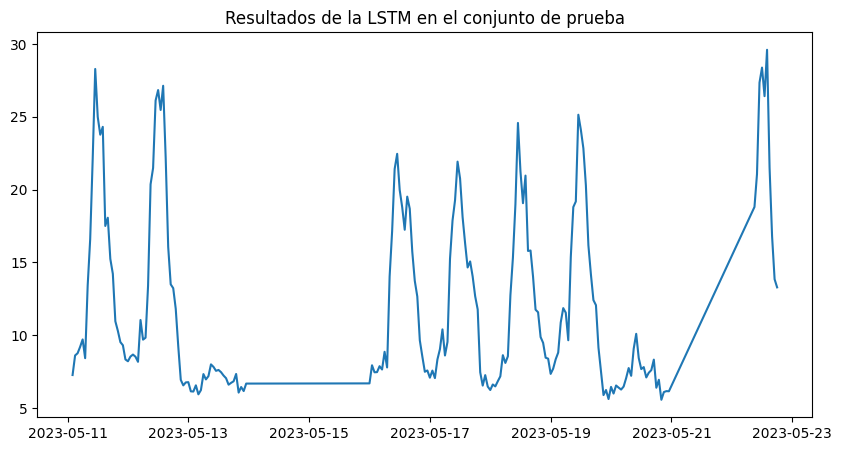

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(df["P1"][1800:2000], label='train')
# Definir rango a resaltar
#fecha_inicio = pd.Timestamp('2024-2-7')
#fecha_fin    = pd.Timestamp('2026-4-20')
# Limitar el eje X al rango deseado
#plt.xlim(fecha_inicio, fecha_fin)

# Resaltar rango
#plt.axvspan(fecha_inicio, fecha_fin, color='orange', alpha=0.3, label='Rango seleccionado')

plt.title('Resultados de la LSTM en el conjunto de prueba')
plt.show()

In [20]:
Xtrain_n[1,0:23,13]

IndexError: index 13 is out of bounds for axis 2 with size 6

In [ ]:
df["pico"].value_counts()


pico
0    11740
1     3040
Name: count, dtype: int64

In [ ]:
Xtest[:,:,2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
Xtrain[:,:,0].max()

40.04925390625

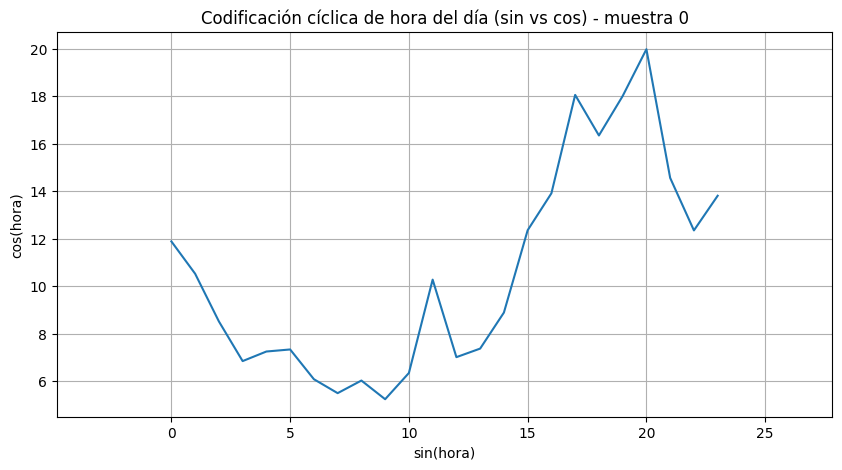

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(Xval[30, :, 0] )
#plt.plot(Xtrain_n[:, :, 7])
#plt.plot(ytrain[0:30])
plt.title("Codificación cíclica de hora del día (sin vs cos) - muestra 0")
plt.xlabel("sin(hora)")
plt.ylabel("cos(hora)")
plt.axis("equal")  # Asegura que los ejes tengan la misma escala
plt.grid(True)
plt.show()

In [ ]:
Xtrain[0, 0, :] 

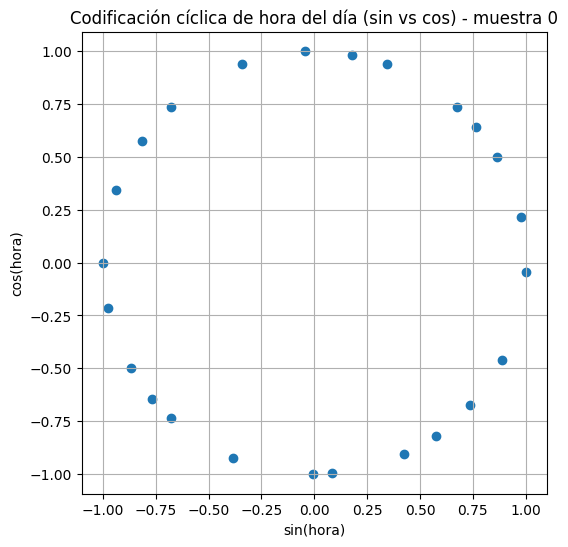

In [ ]:
# Suponiendo que X tiene las columnas correspondientes para sin(hora) y cos(hora)
# Asegúrate de que X[0, :, 4] contiene sin(hora) y X[0, :, 5] contiene cos(hora)
#sin_hora = df['dia_sen'].iloc[:24]
#cos_hora = df['dia_cos'].iloc[:24]
sin_hora = Xtrain[0, :, 2]  # sin(hora)
cos_hora = Xtrain[0, :, 3]  # cos(hora)

# Graficar los puntos como un scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(sin_hora, cos_hora)
plt.title("Codificación cíclica de hora del día (sin vs cos) - muestra 0")
plt.xlabel("sin(hora)")
plt.ylabel("cos(hora)")
plt.axis("equal")  # Asegura que los ejes tengan la misma escala
plt.grid(True)
plt.show()



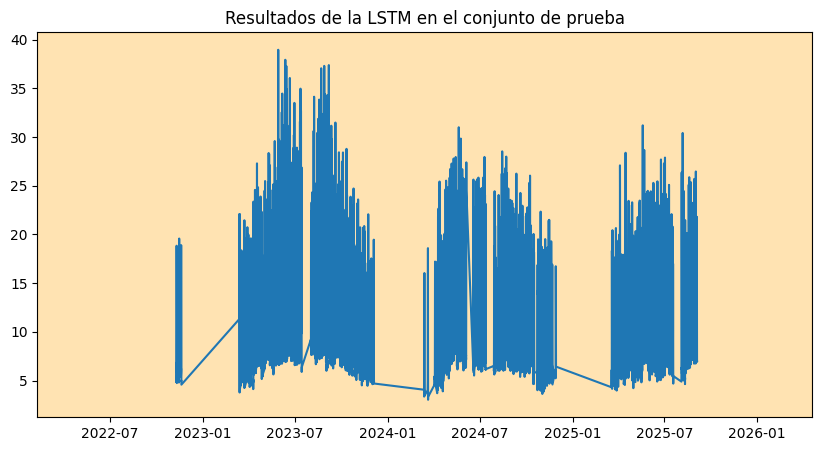

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df["P1"], label='train')
# Definir rango a resaltar
fecha_inicio = pd.Timestamp('2022-2-7')
fecha_fin    = pd.Timestamp('2026-4-20')
# Limitar el eje X al rango deseado
plt.xlim(fecha_inicio, fecha_fin)

# Resaltar rango
plt.axvspan(fecha_inicio, fecha_fin, color='orange', alpha=0.3, label='Rango seleccionado')

plt.title('Resultados de la LSTM en el conjunto de prueba')
plt.show()

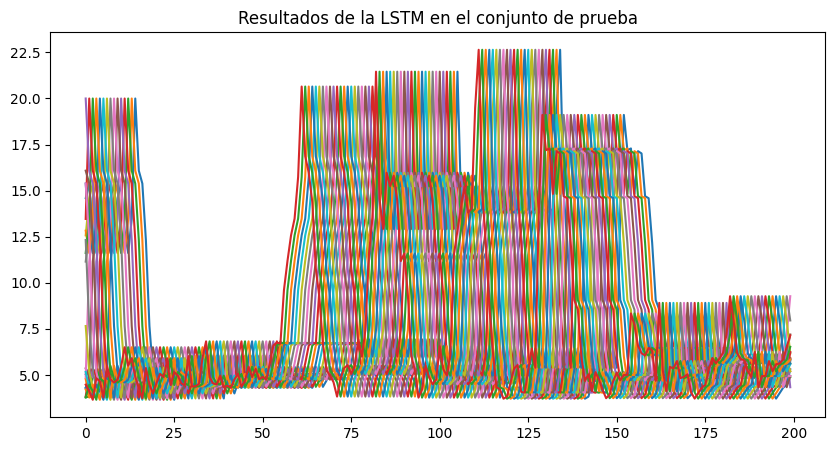

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(Xtrain[:,:,0][0:200], label='train')

plt.title('Resultados de la LSTM en el conjunto de prueba')
plt.show()

In [ ]:
Xtrain[0,0,].shape()

# VISUALIZACION SETS

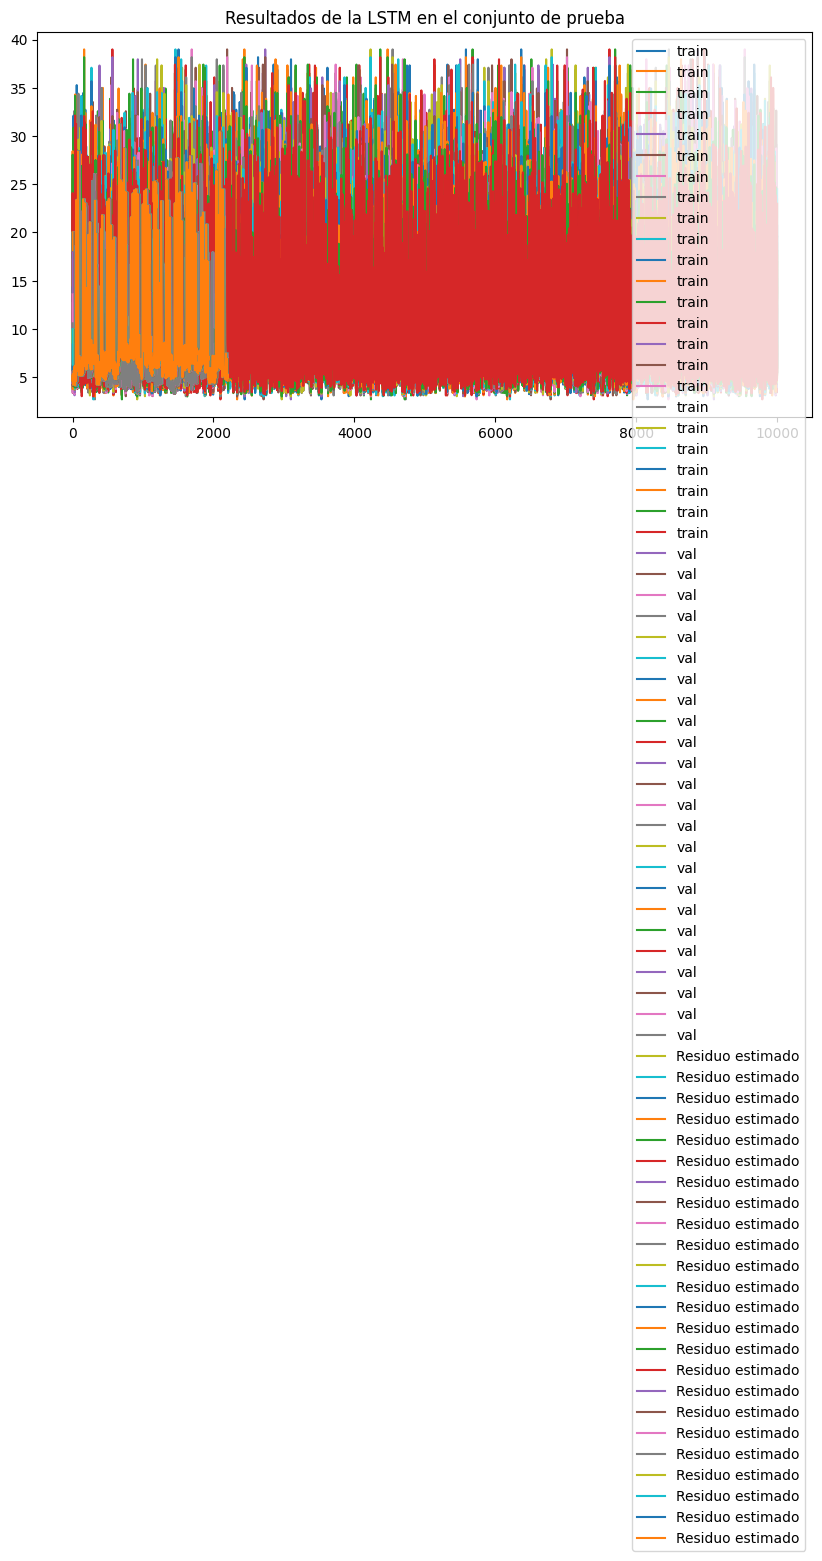

In [251]:
plt.figure(figsize=(10, 5))
plt.plot(ytrain, label='train')
plt.plot(yval, label='val')
plt.plot(ytest, label='Residuo estimado')

plt.legend()
plt.title('Resultados de la LSTM en el conjunto de prueba')
plt.show()

NameError: name 'ytest2' is not defined

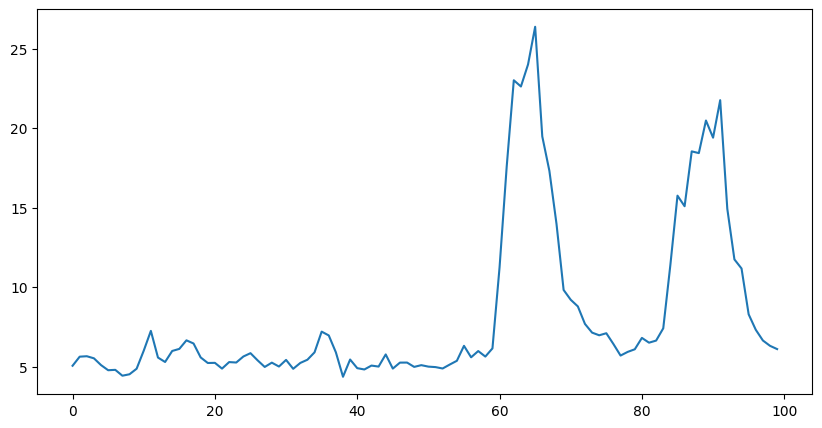

In [147]:
plt.figure(figsize=(10, 5))
plt.plot(ytest[2000:2100], label='Residuo estimado')
plt.plot(ytest2[2000:2100], label='Residuo estimado')

plt.legend()
plt.title('Resultados de la LSTM en el conjunto de prueba')
plt.show()

In [ ]:
con POCOS DATOS, POCA VENTANA CONSIGO PREDICCION OSCILANTE FUERTE, AUMENTO VENTANA
prediccion MEJORA bastante

In [ ]:
import tensorflow as tf

def custom_loss_with_tolerance(y_true, y_pred, tolerance=0.05):
    """
    Error personalizado: si el error relativo es menor al 5% no se penaliza,
    si lo supera, se penaliza normalmente (MSE).
    """
    # Error absoluto relativo
    rel_error = tf.abs((y_true - y_pred) / (y_true + 1e-8))

    # Máscara: 1 si supera tolerancia, 0 si no
    mask = tf.cast(rel_error > tolerance, tf.float32)

    # MSE solo donde error supera tolerancia
    loss = tf.reduce_mean(mask * tf.square(y_true - y_pred))
    return loss


# MODELO


In [252]:
# Mode
# Asegurar reproducibilidad
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, BatchNormalization, Dense, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.losses import MeanAbsolutePercentageError
from tensorflow.keras.layers import MaxPooling1D

import time


np.random.seed(47)
tf.random.set_seed(47)
initializer = GlorotUniform(seed=47)

    # Define los intervalos y los valores de learning rate
boundaries = [5, 10, 20, 50, 100, 250]  # Los límites de los intervalos (épocas en este caso)
values = [0.005, 0.002, 0.001, 0.0001, 0.00005, 0.00001, 0.000001]  # Learning rates correspondientes a los intervalos

    # Crea el scheduler de learning rate
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=boundaries,
        values=values
    )
    # Crear el modelo LSTM
model = Sequential()
#model.add(Conv1D(filters=256, kernel_size=6, activation='relu', input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
#model.add(MaxPooling1D(pool_size=6))  # opcional, reduce la longitud de la secuencia
#model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=3))
model.add(LSTM(256, recurrent_dropout=0.2, return_sequences=False, input_shape=(Xtrain.shape[1], Xtrain.shape[2]), kernel_initializer=initializer ) )
#model.add(Dropout(0.1))
#model.add(BatchNormalization())

#model.add(Dropout(0.2))
#model.add(LSTM(32, recurrent_dropout=0.2, return_sequences=True, kernel_initializer=initializer ) )
#model.add(LSTM(16, recurrent_dropout=0.1, return_sequences=False, kernel_initializer=initializer ) )

#model.add(LSTM(8, recurrent_dropout=0.05, return_sequences=False, kernel_initializer=initializer ) )
    #model.add(BatchNormalization())
    #model.add(Dropout(0.1))
    #model.add(BatchNormalization())

    #model.add(Dropout(0.1))
#model.add(BatchNormalization())
#model.add(Dense(200))
#model.add(Dropout(0.1))

model.add(Dense(ytrain.shape[1]))
#model.add(LSTM(ytrain.shape[1], return_sequences=False))

    # Compilar el modelo con el optimizador personalizado
#optimizer = Adam(learning_rate=lr_schedule, clipnorm=1)
#model.compile(optimizer=optimizer, loss=MeanAbsolutePercentageError())
model.compile(optimizer='adam', loss='mse')


#model.compile(
#    optimizer="adam",
#    loss=lambda y_true, y_pred: custom_loss_with_tolerance(y_true, y_pred, tolerance=0.05)
#)

    # EarlyStopping para evitar sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # ModelCheckpoint para guardar el modelo durante el entrenamiento

start_total = time.time()
        # Entrenar el modelo con datos de validación, EarlyStopping y ModelCheckpoint
history = model.fit(Xtrain_n, ytrain_n, epochs=EPOCAS, verbose=1, batch_size=BATCH_SIZE,
                  validation_data=(Xval_n, yval_n), callbacks=[early_stopping])

total_time = time.time() - start_total
loss_history = history.history['loss']
val_loss_history = history.history.get('val_loss', [None]*len(loss_history))

# Época donde se restauraron los pesos (mejor val_loss)
best_epoch = val_loss_history.index(min(val_loss_history)) if val_loss_history[0] is not None else loss_history.index(min(loss_history))

# Tiempo por época aproximado
epoch_times = [total_time / len(loss_history)] * len(loss_history)  # promedio si no medimos por epoch

# -----------------------------
# 4. Guardar en un DataFrame para luego insertar en BD
# -----------------------------
df_training_info = pd.DataFrame({
    'epoch': list(range(1, len(loss_history)+1)),
    'loss': loss_history,
    'val_loss': val_loss_history,
    'epoch_time_s': epoch_times
})

training_summary = {
    'best_epoch': best_epoch + 1,  # sumo 1 porque los índices empiezan en 0
    'best_val_loss': val_loss_history[best_epoch],
    'total_time_m': total_time/60,
    'early_stopping_patience': PACIENCIA_EARLY
}

print(df_training_info)
print(training_summary)


Epoch 1/300
625/625 [==============================] - 56s 87ms/step - loss: 0.4297 - val_loss: 0.2504
Epoch 2/300
625/625 [==============================] - 52s 84ms/step - loss: 0.3653 - val_loss: 0.2252
Epoch 3/300
625/625 [==============================] - 52s 83ms/step - loss: 0.3378 - val_loss: 0.2369
Epoch 4/300
625/625 [==============================] - 52s 83ms/step - loss: 0.3199 - val_loss: 0.2127
Epoch 5/300
625/625 [==============================] - 51s 82ms/step - loss: 0.3119 - val_loss: 0.2176
Epoch 6/300
625/625 [==============================] - 50s 80ms/step - loss: 0.2969 - val_loss: 0.2024
Epoch 7/300
625/625 [==============================] - 50s 81ms/step - loss: 0.2920 - val_loss: 0.2164
Epoch 8/300
625/625 [==============================] - 51s 81ms/step - loss: 0.2829 - val_loss: 0.2073
Epoch 9/300
625/625 [==============================] - 51s 82ms/step - loss: 0.2722 - val_loss: 0.1972
Epoch 10/300
625/625 [==============================] - 50s 80ms/step - l

In [85]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotUniform
import time
import pandas as pd

np.random.seed(47)
tf.random.set_seed(47)
initializer = GlorotUniform(seed=47)

# Parámetros
K_FOLDS = 5

# Dividir Xtrain en folds
n_samples = Xtrain_n.shape[0]
fold_size = n_samples // K_FOLDS
fold_indices = [(i*fold_size, (i+1)*fold_size if i < K_FOLDS-1 else n_samples) for i in range(K_FOLDS)]

# ---------------------------
# Crear el modelo UNA sola vez
# ---------------------------
model = Sequential()
model.add(LSTM(56, recurrent_dropout=0.2, return_sequences=False,
               input_shape=(Xtrain_n.shape[1], Xtrain_n.shape[2]),
               kernel_initializer=initializer))
model.add(Dense(ytrain_n.shape[1]))
model.compile(optimizer='adam', loss='mse')

histories = []

start_total = time.time()
for k, (start_idx, end_idx) in enumerate(fold_indices):
    print(f"Fold {k+1}/{K_FOLDS}")
    
    # Datos de validación interna del fold
    X_val_fold = Xtrain_n[start_idx:end_idx]
    y_val_fold = ytrain_n[start_idx:end_idx]
    
    # Datos de entrenamiento del fold
    X_train_fold = np.concatenate([Xtrain_n[:start_idx], Xtrain_n[end_idx:]], axis=0)
    y_train_fold = np.concatenate([ytrain_n[:start_idx], ytrain_n[end_idx:]], axis=0)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=PACIENCIA_EARLY, restore_best_weights=True)
    
    # Entrenamiento incremental: el modelo conserva los pesos de fold anteriores
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=EPOCAS,
        batch_size=BATCH_SIZE,
        verbose=1,
        callbacks=[early_stopping]
    )
    
    histories.append(history)

total_time = time.time() - start_total
print(f"Tiempo total de entrenamiento: {total_time/60:.2f} minutos")

# Evaluación final en Xval y Xtest
val_loss_final = model.evaluate(Xval_n, yval_n, verbose=0)
test_loss_final = model.evaluate(Xtest_n, ytest_n, verbose=0)
print("Pérdida final en Xval:", val_loss_final)
print("Pérdida final en Xtest:", test_loss_final)

# Guardar historial del último fold
loss_history = histories[-1].history['loss']
val_loss_history = histories[-1].history.get('val_loss', [None]*len(loss_history))
df_training_info = pd.DataFrame({
    'epoch': list(range(1, len(loss_history)+1)),
    'loss': loss_history,
    'val_loss': val_loss_history
})
print(df_training_info)



Fold 1/5
Epoch 1/300
500/500 [==============================] - 7s 11ms/step - loss: 0.1526 - val_loss: 0.0920
Epoch 2/300
500/500 [==============================] - 6s 12ms/step - loss: 0.0822 - val_loss: 0.0852
Epoch 3/300
500/500 [==============================] - 6s 11ms/step - loss: 0.0776 - val_loss: 0.0895
Epoch 4/300
500/500 [==============================] - 6s 12ms/step - loss: 0.0746 - val_loss: 0.0738
Epoch 5/300
500/500 [==============================] - 6s 12ms/step - loss: 0.0747 - val_loss: 0.0757
Epoch 6/300
500/500 [==============================] - 6s 11ms/step - loss: 0.0729 - val_loss: 0.0741
Epoch 7/300
500/500 [==============================] - 6s 12ms/step - loss: 0.0718 - val_loss: 0.0735
Epoch 8/300
500/500 [==============================] - 6s 12ms/step - loss: 0.0712 - val_loss: 0.0726
Epoch 9/300
500/500 [==============================] - 6s 12ms/step - loss: 0.0700 - val_loss: 0.0715
Epoch 10/300
500/500 [==============================] - 6s 12ms/step - lo

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import LayerNormalization, Dropout, Dense, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping

# ------- Positional Encoding (sin/cos, no entrenable) -------
class SinePositionalEncoding(layers.Layer):
    def __init__(self, d_model, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model

    def call(self, x):
        # x: (batch, T, d_model)
        T = tf.shape(x)[1]
        i = tf.range(self.d_model, dtype=tf.float32)[tf.newaxis, :]  # (1, d_model)
        pos = tf.cast(tf.range(T)[:, tf.newaxis], tf.float32)        # (T, 1)
        div = tf.pow(10000.0, (2*(i//2))/tf.cast(self.d_model, tf.float32))  # (1,d_model)

        pe = tf.where(tf.cast(i % 2, tf.bool),
                      tf.cos(pos/div),
                      tf.sin(pos/div))  # (T, d_model)
        pe = tf.expand_dims(pe, axis=0)  # (1, T, d_model)
        return x + pe  # broadcasting sobre batch

# ------- Bloque Transformer Encoder -------
def transformer_encoder_block(x, num_heads=4, key_dim=32, ff_dim=128, dropout=0.1):
    # Multi-Head Self-Attention
    attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=dropout)(x, x)
    print("After MultiHeadAttention:", attn_out.shape)
    x = LayerNormalization(epsilon=1e-6)(x + attn_out)
    
    # Feed-Forward
    ff = Dense(ff_dim, activation="relu")(x)
    ff = Dropout(dropout)(ff)
    ff = Dense(x.shape[-1])(ff)
    x = LayerNormalization(epsilon=1e-6)(x + ff)
    print("After FeedForward:", x.shape)
    return x

# ------- Parámetros -------
timesteps = Xtrain_n.shape[1]   # tu dataset
features  = Xtrain_n.shape[2]
d_model   = 164
num_heads = 4
key_dim   = d_model // num_heads
ff_dim    = 128
drop      = 0.1

inputs = Input(shape=(timesteps, features))

# LSTM extrae dependencias locales
x = LSTM(128, dropout=0.3, return_sequences=True)(inputs)
x = LSTM(64, dropout=0.1, return_sequences=True)(x)

x = Dense(d_model)(x)
x = SinePositionalEncoding(d_model)(x)

# Encoder stack
x = transformer_encoder_block(x, num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout=drop)
x = transformer_encoder_block(x, num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout=drop)

print("Shape before pooling:", x.shape)
x = GlobalAveragePooling1D()(x)
print("Shape after pooling:", x.shape)

x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(ytrain_n.shape[1])(x)  # 6 pasos de salida

model_tft = Model(inputs, outputs)
model_tft.compile(optimizer='adam', loss='mae')
model_tft.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_tft.fit(Xtrain_n, ytrain_n,
          validation_data=(Xval_n, yval_n),
          epochs=300,
          batch_size=64,
          callbacks=[early_stopping])



In [28]:
import pandas as pd

# Datos
data = {
    'timestamp': [
        '2025-08-27 12:00', '2025-08-27 13:00', '2025-08-27 14:00', '2025-08-27 15:00',
        '2025-08-27 16:00', '2025-08-27 17:00', '2025-08-27 18:00', '2025-08-27 19:05',
        '2025-08-27 20:00', '2025-08-27 21:00', '2025-08-27 22:00', '2025-08-27 23:00',
        '2025-08-28 00:00', '2025-08-28 01:00', '2025-08-28 02:00', '2025-08-28 03:00',
        '2025-08-28 04:00', '2025-08-28 05:00', '2025-08-28 06:05', '2025-08-28 07:00',
        '2025-08-28 08:00', '2025-08-28 09:00', '2025-08-28 10:00', '2025-08-28 11:00'
    ],
    'activa': [
        13.95, 17.16, 12.66, 11.23, 13.59, 16.77, 13.96, 12.47,
        9.14, 9.30, 8.47, 6.27, 6.65, 7.67, 7.08, 6.58,
        6.49, 8.91, 6.49, 8.54, 9.87, 12.88, 13.69, 12.92
    ]
}

# Crear DataFrame
df2 = pd.DataFrame(data)

# Convertir 'time' a datetime
#df2['time'] = pd.to_datetime(df['time'])

# Mostrar
#print(df2)


In [192]:
def codificar_tiempo(df):
    df2 = df.copy()

    # Asegurar que la columna 'timestamp' esté en formato datetime
    df2['timestamp'] = pd.to_datetime(df2['timestamp'], errors='coerce')

    if df2['timestamp'].isnull().any():
        raise ValueError("Algunas fechas no pudieron convertirse a datetime.")

    # Codificación del tiempo del día
    df2['tiempo_del_dia'] = df2['timestamp'].dt.hour + df2['timestamp'].dt.minute / 60.0
    df2['dia_sen'] = np.sin(2 * np.pi * df2['tiempo_del_dia'] / 24)
    df2['dia_cos'] = np.cos(2 * np.pi * df2['tiempo_del_dia'] / 24)

    # Codificación del día del año con ajuste por año bisiesto
    df2['dia_del_año'] = df2['timestamp'].dt.dayofyear
    dias_en_el_anio = df2['timestamp'].dt.is_leap_year.map(lambda x: 366 if x else 365)
    df2['mes_sen'] = np.sin(2 * np.pi * df2['dia_del_año'] / dias_en_el_anio)
    df2['mes_cos'] = np.cos(2 * np.pi * df2['dia_del_año'] / dias_en_el_anio)

    # Cálculo de diferencia y detección de picos
    df2['diferencia_activa'] = df2['activa'].diff()
    df2['pico'] = np.where(np.abs(df2['diferencia_activa']) > 3, 1, 0)

    # Selección de columnas finales
    df2 = df2[['activa', 'pico' , 'dia_sen', 'dia_cos', 'mes_sen', 'mes_cos', 'timestamp']]

    logging.info("Codificación de tiempo completada.")

    return df2



def escalar_datos(Xtrain, ytrain, scalers):
    Xtrain_n = Xtrain.copy()

    Xtrain_n[:, :, 0] = scalers['scaleractiva'].transform(Xtrain[:, :, 0])
    Xtrain_n[:, :, 2] = scalers['scalersenhora'].transform(Xtrain[:, :, 1]) 
    Xtrain_n[:, :, 3] = scalers['scalercoshora'].transform(Xtrain[:, :, 2])
    Xtrain_n[:, :, 4] = scalers['scalersendia'].transform(Xtrain[:, :, 3])
    Xtrain_n[:, :, 5] = scalers['scalercosdia'].transform(Xtrain[:, :, 4])

    ytrain_n = ytrain.copy()
    ytrain_n = ytrain_n.reshape(-1, 1)  
    ytrain_n = scalers['salidas'].transform(ytrain_n)  

    logging.info("datos escalados")
    return Xtrain_n, ytrain_n


def escalar_entrada(Xtrain, scalers):
    Xtrain_n = Xtrain.copy()

    Xtrain_n[:, :, 0] = scalers['scaleractiva'].transform(Xtrain[:, :, 0])
    #Xtrain_n[:, :, 1] = scalers['scalersenhora'].transform(Xtrain[:, :, 1]) 
    #Xtrain_n[:, :, 2] = scalers['scalercoshora'].transform(Xtrain[:, :, 2])
    #Xtrain_n[:, :, feature_suavizado] = scalermedia.transform(Xtrain[:, :, feature_suavizado])
    #Xtrain_n[:, :, feature_estandar] = scalerestandar.transform(Xtrain[:, :, feature_estandar])

    logging.info("entrada escalada")
    return Xtrain_n

def crear_ventana_dataset(dataset, ventana):
    X = []
    logging.info("Creando ventanas.")

    # Añadir columnas de días de la semana
    dataset['lunes']     = (dataset['timestamp'].dt.dayofweek == 0).astype(int)
    dataset['martes']    = (dataset['timestamp'].dt.dayofweek == 1).astype(int)
    dataset['miercoles'] = (dataset['timestamp'].dt.dayofweek == 2).astype(int)
    dataset['jueves']    = (dataset['timestamp'].dt.dayofweek == 3).astype(int)
    dataset['viernes']   = (dataset['timestamp'].dt.dayofweek == 4).astype(int)
    dataset['sabado']    = (dataset['timestamp'].dt.dayofweek == 5).astype(int)
    dataset['domingo']   = (dataset['timestamp'].dt.dayofweek == 6).astype(int)
    dataset['dia_habil'] = dataset['timestamp'].dt.dayofweek < 5  # True si lunes-viernes
    dataset['dia_habil'] = dataset['dia_habil'].astype(int)
    print(dataset.columns)

    # Verificar tamaño
    if len(dataset) < ventana:
        logging.warning("El tamaño del dataset es menor que la ventana. No se pueden crear ventanas.")
        return np.array(X)  # Retorno vacío

    # Crear ventanas
    for i in range(len(dataset) - ventana + 1):
        # Crear la ventana
        window = dataset.iloc[i:i + ventana].copy()

        # Rolling aplicado SOLO a la ventana
        roll_mean = window['activa'].rolling(4).mean().bfill().values
        roll_std  = window['activa'].rolling(4).std().bfill().values

        # Características principales
        window_features = window[['activa', 'pico', 'dia_sen', 'dia_cos', 
                                  'mes_sen', 'mes_cos','dia_habil']]
                                  #,'lunes','martes','miercoles','jueves','viernes','sabado','domingo']].values
        
        """# Extender con estadísticas de rolling
        ventana_ext = np.hstack([window_features, 
                                 roll_mean.reshape(-1,1), 
                                 roll_std.reshape(-1,1)])
        
        X.append(ventana_ext)"""
        X.append(window_features)

    # Convertir a array
    X = np.array(X)
    logging.info("Ventanas creadas")

    return X

In [255]:
df2 = codificar_tiempo(df2)
#print(df2)


X2= crear_ventana_dataset(df2,24)
X2_n = escalar_entrada(X2,scalers)
predicciones = model.predict(X2_n, batch_size=1)
predicciones = salidas.inverse_transform(predicciones)

Index(['activa', 'pico', 'dia_sen', 'dia_cos', 'mes_sen', 'mes_cos',
       'timestamp', 'lunes', 'martes', 'miercoles', 'jueves', 'viernes',
       'sabado', 'domingo', 'dia_habil'],
      dtype='object')
1/1 [==============================] - 0s 193ms/step


In [ ]:
TIENE QUE DAR 18.1 || promedio de esa hora 13.745

In [256]:
predicciones

array([[17.93201]], dtype=float32)

In [ ]:
predicciones_tr = model_tft.predict(X2_n, batch_size=1)
predicciones_tr = salidas.inverse_transform(predicciones_tr)
print(predicciones_tr)

In [113]:
ypred_n = model.predict(Xtest_n)
ypred = salidas.inverse_transform(ypred_n)

16/16 [==============================] - 0s 4ms/step


In [176]:
ypred_n_tft = model_tft.predict(Xtest_n)
ypred_tft = salidas.inverse_transform(ypred_n_tft)

20/20 [==============================] - 1s 21ms/step


In [35]:
ini = 1
fin = 499

In [114]:
plt.figure(figsize=(10, 5))
pers = abs(ytest[ini:fin+1,0] - ytest[ini-1:fin,0])
err = abs(ypred[ini:fin,0] - ytest[ini:fin,0])
#plt.plot(ypred_tft[2000:2100], label='tft')
plt.plot(ypred[3200:3300], label='lstm')
#plt.plot(ytest[2000:2100], label="realf")



plt.legend()
plt.title('Resultados de la LSTM en el conjunto de prueba')
plt.show()

NameError: name 'ini' is not defined

<Figure size 1000x500 with 0 Axes>

In [115]:
plt.figure(figsize=(10, 5))
pers = abs(ytest[ini:fin+1,0] - ytest[ini-1:fin,0])
err = abs(ypred[ini:fin,0] - ytest[ini:fin,0])
#err2 = abs(ypred_tft[ini:fin,0] - ytest[ini:fin,0])
plt.plot(pers[:], label='Pers')
plt.plot(err[:], label="pred")


plt.legend()
plt.title('Resultados de la LSTM en el conjunto de prueba')
plt.show()

NameError: name 'ini' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
pers = pers[:-1]

# PREDICCIONES Y STATS

In [124]:
        ypred_n = model.predict(Xtest_n)
        ypred = salidas.inverse_transform(ypred_n)


        if ytest.ndim == 1:
            # Caso univariado: vector 1D
            cambios = np.abs(np.diff(ytest, prepend=ytest[0]))

        elif ytest.ndim == 2:
            # Caso multistep: matriz (N, m)
            # Tomamos diff entre filas, preservando columnas
            cambios = np.abs(np.diff(ytest, axis=0, prepend=ytest[0:1, :]))

        # Máscara: True cuando el cambio supera el umbral
        mask = cambios > PICO_CONSIDERABLE

        # Error porcentual general
        error_percentual = np.abs(ypred - ytest) / np.abs(ytest) * 100

        # Aplicar la máscara
        error_filtrado = error_percentual[mask]



        mejor_que_persistente = 0
        total_comparaciones = 0
        porcentaje_mejora_lstm = 0
        errores_peores_que_persistencia = []
        desplazamiento = 1
        for i in range(desplazamiento, ytest.shape[0]):
            valor_real = ytest[i, -1]                    # último valor real
            valor_anterior = ytest[i - desplazamiento, -1]  # valor anterior con el desplazamiento adecuado
            pred_modelo = ypred[i, -1]        # predicción del modelo en ese punto

            diferencia_real = abs(valor_real - valor_anterior)

            # Solo comparar si la diferencia con el valor anterior (persistencia) es relevante
            if diferencia_real > PICO_CONSIDERABLE:
                error_modelo = abs(valor_real - pred_modelo)
                error_persistente = abs(valor_real - valor_anterior)

                if error_modelo < (error_persistente):
                    mejor_que_persistente += 1
                else:
                    errores_peores_que_persistencia.append(i)

                total_comparaciones += 1

        if total_comparaciones > 0:
            porcentaje_mejora = (mejor_que_persistente / total_comparaciones) * 100
            porcentaje_mejora_lstm = porcentaje_mejora
        else:
            porcentaje_mejora = 0


        mejor_que_persistente = 0
        total_comparaciones = 0
        porcentaje_mejora_lstm05 = 0
        errores_peores_que_persistencia = []
        desplazamiento = 1
        for i in range(desplazamiento, ytest.shape[0]):
            valor_real = ytest[i, -1]                    # último valor real
            valor_anterior = ytest[i - desplazamiento, -1]  # valor anterior con el desplazamiento adecuado
            pred_modelo = ypred[i, -1]        # predicción del modelo en ese punto

            diferencia_real = abs(valor_real - valor_anterior)

            # Solo comparar si la diferencia con el valor anterior (persistencia) es relevante
            if diferencia_real > PICO_CONSIDERABLE:
                error_modelo = abs(valor_real - pred_modelo)
                error_persistente = abs(valor_real - valor_anterior)

                if error_modelo < (error_persistente*0.5):
                    mejor_que_persistente += 1
                else:
                    errores_peores_que_persistencia.append(i)

                total_comparaciones += 1

        if total_comparaciones > 0:
            porcentaje_mejora = (mejor_que_persistente / total_comparaciones) * 100
            porcentaje_mejora_lstm05 = porcentaje_mejora
        else:
            porcentaje_mejora = 0
        print("cant datos", cantidad_picos)
        print("datos: % mejora", porcentaje_mejora_lstm, " %0.5: ", porcentaje_mejora_lstm05)





        
        epsilon = 1e-8
        ventana_salida = ypred.shape[1]
        n = ytest.shape[0]

        # ============================
        # Construir persistencia clásica (mantener último valor)
        # ============================
        persistencias = np.zeros((n, ventana_salida))

        # Para todos los pasos futuros, repetimos el valor en t
        # Por eso, desplazamos la serie una vez
        persistencias[1:, :] = ytest[:-1, 0].reshape(-1, 1)   # repetir en todas las columnas
        persistencias[0, :]  = ytest[0, 0]                    # relleno inicial

        # ============================
        # Calcular errores
        # ============================
        errores_persistencia = np.abs(persistencias - ytest[:, 0:ventana_salida])
        error_rel_persist = np.mean(np.abs((persistencias - ytest[:, 0:ventana_salida]) / (ytest[:, 0:ventana_salida] )), axis=0) * 100

        errores_modelo = np.abs(ypred - ytest[:, 0:ventana_salida])
        error_rel_modelo = np.mean(np.abs((ypred - ytest[:, 0:ventana_salida]) / (ytest[:, 0:ventana_salida] )), axis=0) * 100

        # ============================
        # Estadísticos por paso
        # ============================
        error_prom_modelo = np.mean(errores_modelo, axis=0)
        error_std_modelo  = np.std(errores_modelo, axis=0)

        error_prom_persist = np.mean(errores_persistencia, axis=0)
        error_std_persist  = np.std(errores_persistencia, axis=0)

        # ============================
        # Impresión
        # ============================
        print("Error promedio modelo por paso:", error_prom_modelo)
        print("Desvío estándar modelo por paso:", error_std_modelo)
        print("Error relativo % modelo por paso:", error_rel_modelo)

        print("Error promedio persistencia por paso:", error_prom_persist)
        print("Desvío estándar persistencia por paso:", error_std_persist)
        print("Error relativo % persistencia por paso:", error_rel_persist)

       

69/69 [==============================] - 0s 4ms/step
cant datos 1686
datos: % mejora 70.8185053380783  %0.5:  38.79003558718861
Error promedio modelo por paso: [1.09124538 1.40755986 1.63123869 1.80209269 1.98494059 2.18751854]
Desvío estándar modelo por paso: [1.24518148 1.63527819 1.93090711 2.25409484 2.44327583 2.57337202]
Error relativo % modelo por paso: [11.49508929 14.76167015 17.04076794 18.52373997 20.63364846 23.511478  ]
Error promedio persistencia por paso: [1.25005705 2.07583991 2.87439955 3.58169807 4.21061866 4.74804186]
Desvío estándar persistencia por paso: [1.59354167 2.64141986 3.52458539 4.29784528 4.89782176 5.34913753]
Error relativo % persistencia por paso: [11.50538675 18.68695478 25.90509416 32.54405926 39.19036203 45.516799  ]


# stats multivariable


In [253]:
import numpy as np
ypred_n = model.predict(Xtest_n)
ypred = salidas.inverse_transform(ypred_n)

desplazamiento = 1         # usar último valor conocido

# ypred_n = model.predict(Xtest_n)
# ypred = salidas.inverse_transform(ypred_n)

n = ytest.shape[0]

# ============================
# Construir persistencia clásica: mantener último valor conocido (t-1)
# ============================
persistencias = np.zeros((n, ventana_salida))
persistencias[1:, :] = ytest[:-1, 0].reshape(-1, 1)  # replicar último valor completo en todas las columnas
persistencias[0, :] = ytest[0, 0]                    # relleno inicial

# ============================
# Detectar picos por columna
# ============================
if ytest.ndim == 1:
    cambios = np.abs(np.diff(ytest, prepend=ytest[0]))
elif ytest.ndim == 2:
    cambios = np.abs(np.diff(ytest, axis=0, prepend=ytest[0:1, :]))

mask = cambios > PICO_CONSIDERABLE

# ============================
# Calcular errores absolutos y relativos
# ============================
errores_modelo = np.abs(ypred - ytest)
errores_persistencia = np.abs(persistencias - ytest)

error_rel_modelo = np.mean(np.abs(errores_modelo / (ytest)), axis=0) * 100
error_rel_persistencia = np.mean(np.abs(errores_persistencia / (ytest)), axis=0) * 100

# ============================
# Porcentaje de mejora del modelo vs persistencia
# ============================
porcentaje_mejora = np.zeros(ventana_salida)
porcentaje_mejora50 = np.zeros(ventana_salida)

for k in range(ventana_salida):
    mejor = 0
    mejor50 = 0
    total = 0
    for i in range(desplazamiento, n):
        if mask[i, k]:
            error_m = abs(ypred[i, k] - ytest[i, k])
            error_p = abs(persistencias[i, k] - ytest[i, k])
            if error_m < error_p:
                mejor += 1
            if error_m < 0.5 * error_p:
                mejor50 += 1
            total += 1
    if total > 0:
        porcentaje_mejora[k] = 100 * mejor / total
        porcentaje_mejora50[k] = 100 * mejor50 / total
    
# ============================
# Estadísticos
# ============================
error_prom_modelo = np.mean(errores_modelo, axis=0)
error_std_modelo  = np.std(errores_modelo, axis=0)
error_prom_persist = np.mean(errores_persistencia, axis=0)
error_std_persist  = np.std(errores_persistencia, axis=0)

# ============================
# Impresión
# ============================
print("Error promedio modelo por paso:", error_prom_modelo)
print("Desvío estándar modelo por paso:", error_std_modelo)
print("Error relativo % modelo por paso:", error_rel_modelo)
print("")
print("Error promedio persistencia por paso:", error_prom_persist)
print("Desvío estándar persistencia por paso:", error_std_persist)
print("Error relativo % persistencia por paso:", error_rel_persistencia)
print("")
print("Porcentaje de mejora vs persistencia por paso:", porcentaje_mejora)
print("Porcentaje de mejora >50% vs persistencia por paso:", porcentaje_mejora50)
print(total)

69/69 [==============================] - 2s 27ms/step
Error promedio modelo por paso: [1.0071974  1.25914138 1.46951029 1.70431177 1.83815914 1.97486798
 2.13471861 2.21456415 2.30240846 2.35898821 2.39389933 2.47039453
 2.50611013 2.54404295 2.59607142 2.55674425 2.53775372 2.5302695
 2.50020095 2.46777812 2.44629306 2.36181714 2.34742452 2.30495609]
Desvío estándar modelo por paso: [1.16254906 1.55684409 1.88988553 2.22816978 2.47420921 2.64511524
 2.78048152 2.8617429  2.92541304 3.00817992 3.06220472 3.14113684
 3.24231305 3.23154308 3.26562272 3.21261028 3.12514559 3.12340323
 3.0079822  2.99893691 2.93450052 2.91354099 2.85531199 2.86022032]
Error relativo % modelo por paso: [10.42290834 12.78322702 14.75489339 17.17540004 18.27220625 20.29062237
 22.02020911 23.02852982 24.60960101 25.73015335 26.52864598 27.65618094
 28.36811236 29.12747609 30.26137497 30.16152125 29.8842626  30.07076615
 29.72436659 29.44641181 29.660192   28.46267729 28.48698403 27.85684094]

Error promedio p

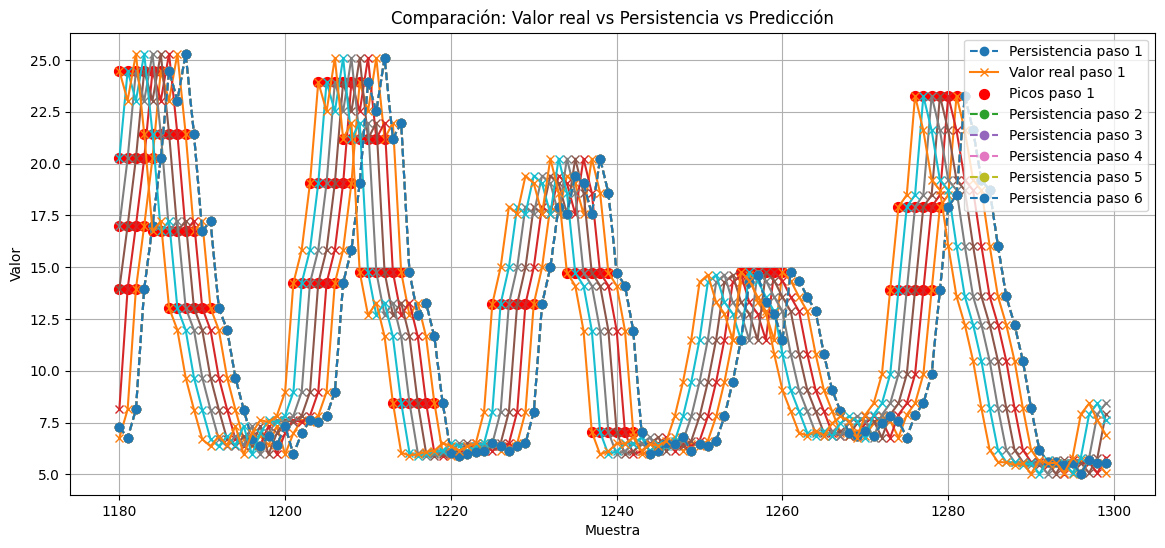

In [132]:
import matplotlib.pyplot as plt
import numpy as np

# Rango de muestras a graficar
start = 1180
end = 1300  # ajustá según tus datos

plt.figure(figsize=(14,6))

for k in range(ventana_salida):
    # Persistencia: último valor conocido replicado
    plt.plot(range(start, end), persistencias[start:end, k], marker='o', linestyle='--', label=f'Persistencia paso {k+1}')

    # Valor real
    plt.plot(range(start, end), ytest[start:end, k], marker='x', linestyle='-', label=f'Valor real paso {k+1}' if k==0 else None)

    # Marca picos relevantes
    picos = np.where(mask[start:end, k])[0] + start
    plt.scatter(picos, ytest[picos, k], color='red', s=50, label=f'Picos paso {k+1}' if k==0 else None)

# Predicción del modelo (ejemplo, paso 1)
#plt.plot(range(start, end), ypred[start:end, 0], 'r-', linewidth=2, label='Predicción modelo paso 1')

plt.xlabel('Muestra')
plt.ylabel('Valor')
plt.title('Comparación: Valor real vs Persistencia vs Predicción')
plt.legend()
plt.grid(True)
plt.show()


In [184]:
# Índice de la muestra que querés evaluar
i = 245  # por ejemplo

# Error absoluto por columna
errores_persist_i = np.abs(persistencias[i, :] - ytest[i, :])
errores_modelo_i  = np.abs(ypred[i, :] - ytest[i, :])

# Error relativo % por columna
error_rel_persist_i = np.abs(errores_persist_i / (ytest[i, :] )) * 100
error_rel_modelo_i  = np.abs(errores_modelo_i  / (ytest[i, :] )) * 100

# Promedio de la muestra (sobre todas las columnas)
error_prom_persist_i = np.mean(errores_persist_i)
error_prom_modelo_i  = np.mean(errores_modelo_i)
error_rel_prom_persist_i = np.mean(error_rel_persist_i)
error_rel_prom_modelo_i  = np.mean(error_rel_modelo_i)
print("habia en la muestra", ytest[i, :])
print("en persistencia", persistencias[i, :])
print(f"Muestra {i} - Error absoluto por columna (persistencia):", errores_persist_i)
print(f"Muestra {i} - Error absoluto por columna (modelo):", errores_modelo_i)
print(f"Muestra {i} - Error relativo % por columna (persistencia):", error_rel_persist_i)
print(f"Muestra {i} - Error relativo % por columna (modelo):", error_rel_modelo_i)
print(f"Muestra {i} - Error promedio total persistencia:", error_prom_persist_i)
print(f"Muestra {i} - Error promedio total modelo:", error_prom_modelo_i)
print(f"Muestra {i} - Error relativo promedio % persistencia:", error_rel_prom_persist_i)
print(f"Muestra {i} - Error relativo promedio % modelo:", error_rel_prom_modelo_i)


habia en la muestra [6.87886262]
en persistencia [6.51859814]
Muestra 245 - Error absoluto por columna (persistencia): [0.36026447]
Muestra 245 - Error absoluto por columna (modelo): [0.13395714]
Muestra 245 - Error relativo % por columna (persistencia): [5.23726801]
Muestra 245 - Error relativo % por columna (modelo): [1.94737344]
Muestra 245 - Error promedio total persistencia: 0.3602644708806819
Muestra 245 - Error promedio total modelo: 0.13395714361017408
Muestra 245 - Error relativo promedio % persistencia: 5.237268005229785
Muestra 245 - Error relativo promedio % modelo: 1.9473734409238848


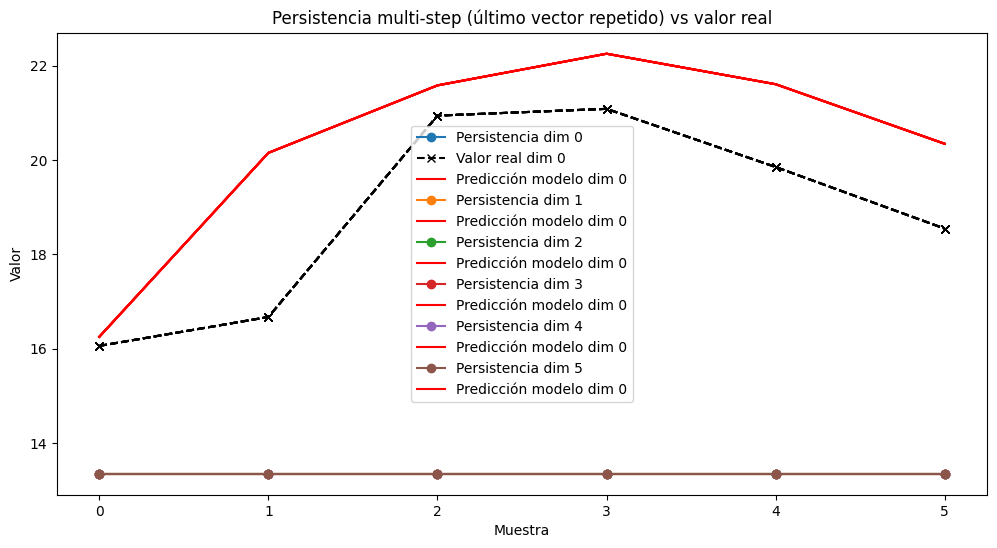

In [139]:
start, end = 190, 200
plt.figure(figsize=(12,6))

for k in range(ventana_salida):
    plt.plot(persistencias[265], marker='o', label=f'Persistencia dim {k}')
    plt.plot(ytest[265], 'k--', marker='x', label=f'Valor real dim {k}' if k==0 else None)
    plt.plot(ypred[265], 'r-', label='Predicción modelo dim 0')
#plt.plot(ypred[start:end, 0], 'r-', label='Predicción modelo dim 0')

plt.xlabel('Muestra')
plt.ylabel('Valor')
plt.title('Persistencia multi-step (último vector repetido) vs valor real')
plt.legend()
plt.show()

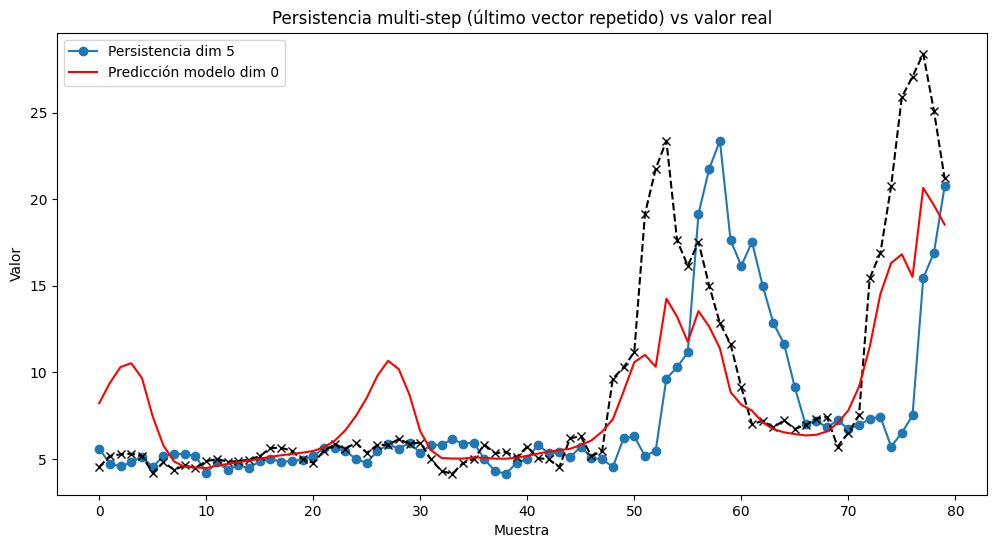

In [137]:
start, end = 190, 200
plt.figure(figsize=(12,6))


plt.plot(persistencias[20:100,4], marker='o', label=f'Persistencia dim {k}')
plt.plot(ytest[20:100,4], 'k--', marker='x', label=f'Valor real dim {k}' if k==0 else None)
plt.plot(ypred[20:100,4], 'r-', label='Predicción modelo dim 0')
#plt.plot(ypred[start:end, 0], 'r-', label='Predicción modelo dim 0')

plt.xlabel('Muestra')
plt.ylabel('Valor')
plt.title('Persistencia multi-step (último vector repetido) vs valor real')
plt.legend()
plt.show()

In [110]:
ytest[30]

array([4.81469416, 4.37106208, 4.62854233, 4.47652912, 4.87190456,
       4.99809604])

In [108]:
ypred[30]

array([5.047775 , 4.83867  , 4.5362644, 4.8896227, 4.4763126, 4.2112393],
      dtype=float32)

In [109]:
persistencias[30]

array([4.19442075, 4.19442075, 4.19442075, 4.19442075, 4.19442075,
       4.19442075])

In [121]:
        mejor_que_persistente = 0
        total_comparaciones = 0
        porcentaje_mejora = 0
        porcentaje_merora_tft = 0
        errores_peores_que_persistencia = []
        desplazamiento = 1
        for i in range(desplazamiento, ytest.shape[0]):
            valor_real = ytest[i, -1]                    # último valor real
            valor_anterior = ytest[i - desplazamiento, -1]  # valor anterior con el desplazamiento adecuado
            pred_modelo = ypred_tft[i, -1]        # predicción del modelo en ese punto

            diferencia_real = abs(valor_real - valor_anterior)

            # Solo comparar si la diferencia con el valor anterior (persistencia) es relevante
            if diferencia_real >= 3:
                error_modelo = abs(valor_real - pred_modelo)
                error_persistente = abs(valor_real - valor_anterior)

                if error_modelo < (error_persistente):
                    mejor_que_persistente += 1
                else:
                    errores_peores_que_persistencia.append(i)

                total_comparaciones += 1

        if total_comparaciones > 0:
            porcentaje_mejora = (mejor_que_persistente / total_comparaciones) * 100
            porcentaje_merora_tft = porcentaje_mejora
        else:
            porcentaje_mejora = 0

NameError: name 'ypred_tft' is not defined

In [ ]:
total_comparaciones

131

In [ ]:
print(porcentaje_mejora_lstm)
print(porcentaje_mejora_lstm05)



50.38167938931297
28.24427480916031


In [ ]:
print(porcentaje_merora_lstm)
#print(porcentaje_merora_tft)

54.19847328244275


In [ ]:
print(porcentaje_merora_lstm)

27.06964520367937


In [ ]:
87.31563421828909- al 50 40.41297935103245
MEZCLANDO TRIAN
85.83815028901735   43.352601156069367

In [ ]:
80 era el anterior, ahora con idem modelo + capa densa 200 me dio 59... todo con 0% de mejora
-----
85.1528384279476 lstm - tft
83.1877729257642  me dio con P,I, sin dia habil 
----
Con el doble de entrada ahora dio 
83.51648351648352
86.37362637362638
---
con el quintuple
83.4090909090909
87.04545454545455

-----------
sacando la corriente mejoro...

In [ ]:
# condición booleana
mejora = err < pers 

# contar cuántas veces ocurre
cantidad = np.sum(mejora)

# porcentaje respecto al total
porcentaje = cantidad / len(err) * 100

print(f"Cantidad de veces que la LSTM mejora a la persistencia: {cantidad}")
print(f"Porcentaje: {porcentaje:.2f}%")

NameError: name 'err' is not defined

In [ ]:
valor = 1520

In [ ]:
print("p: ",ypred[valor]," real:",ytest[valor])

In [ ]:
ypred.shape

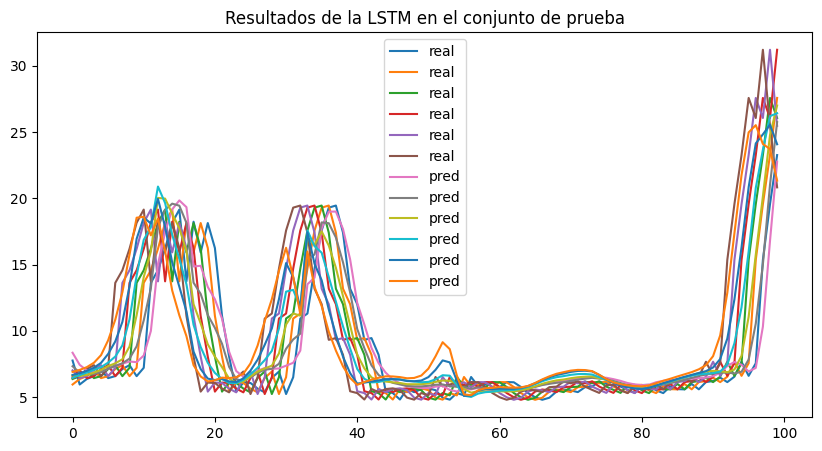

In [222]:
plt.figure(figsize=(10, 5))
plt.plot(ytest[0:100], label='real')
plt.plot(ypred[0:100], label='pred')



plt.legend()
plt.title('Resultados de la LSTM en el conjunto de prueba')
plt.show()

# VISUALIZACION PREDICCIONES

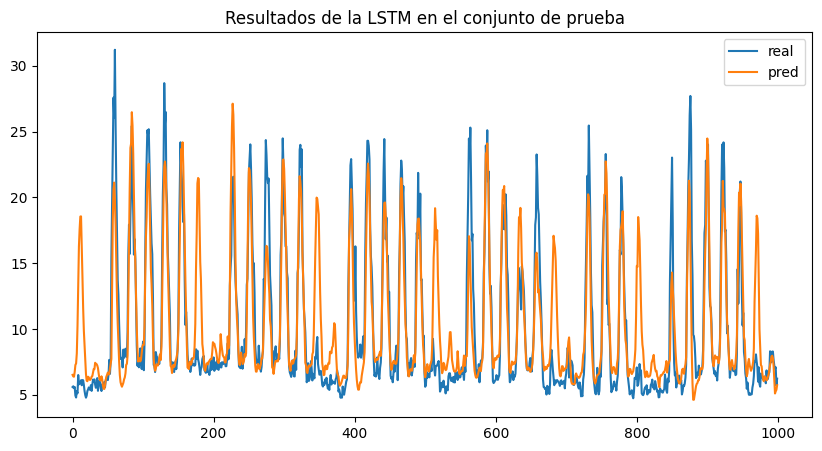

In [261]:
plt.figure(figsize=(10, 5))
plt.plot(ytest[600:1600,23], label='real')
plt.plot(ypred[600:1600,23], label='pred')
#plt.plot(ypred_tft[4500:4550,0], label='predtft')



plt.legend()
plt.title('Resultados de la LSTM en el conjunto de prueba')
plt.show()

NameError: name 'ypred_tft' is not defined

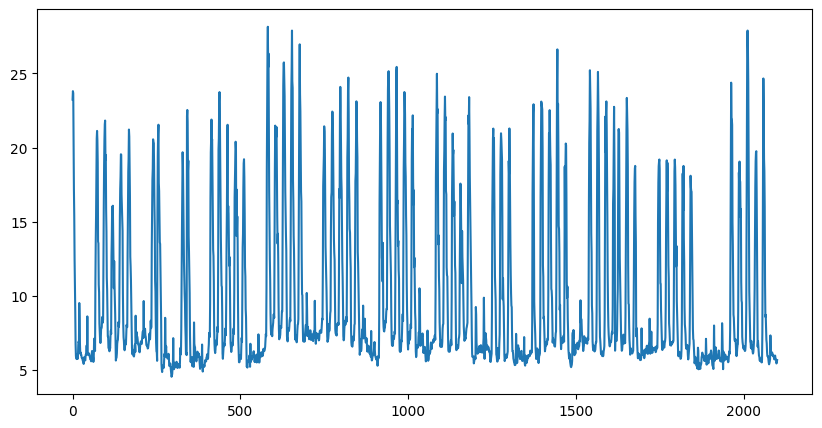

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(ypred[100:5000,0], label='Predicho')
plt.plot(ypred_tft[100:5000,0], label='Predicho tft')
plt.plot(ytest[100:5000,0], label='Real')

plt.legend()
plt.title('Resultados de la LSTM en el conjunto de prueba')
plt.show()

In [204]:
error_pred = abs(ypred-ytest)
error_pred_tft = abs(ypred_tft-ytest)

NameError: name 'ypred_tft' is not defined

NameError: name 'error_pred_tft' is not defined

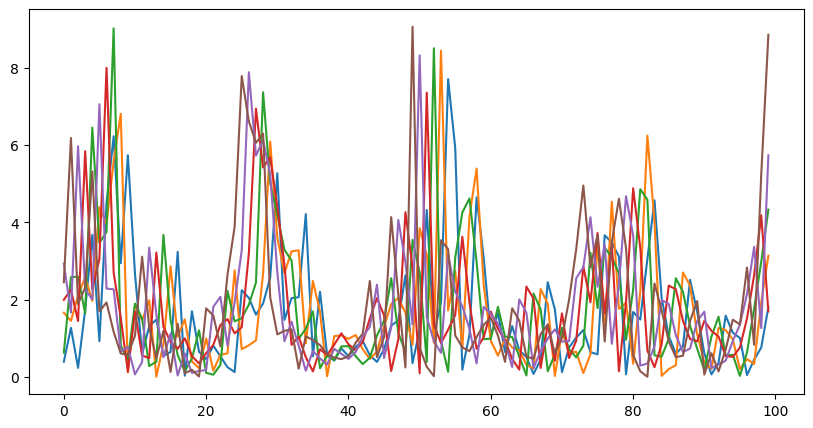

In [227]:
plt.figure(figsize=(10, 5))
plt.plot(error_pred[0:100], label='Predicho')
plt.plot(error_pred_tft[0:100], label='Predicho tft')

plt.legend()
plt.title('Resultados de la LSTM en el conjunto de prueba')
plt.show()

In [ ]:
error_percentual = np.abs(ypred - ytest) / np.abs(ytest) * 100


NameError: name 'ypred_tft' is not defined

In [ ]:
cambios = np.abs(np.diff(ytest, prepend=ytest[0]))

# Máscara: True cuando el cambio supera el umbral
mask = cambios > PICO_CONSIDERABLE

# Error porcentual general
error_percentual = np.abs(ypred - ytest) / np.abs(ytest) * 100

# Aplicar la máscara
error_filtrado = error_percentual[mask]

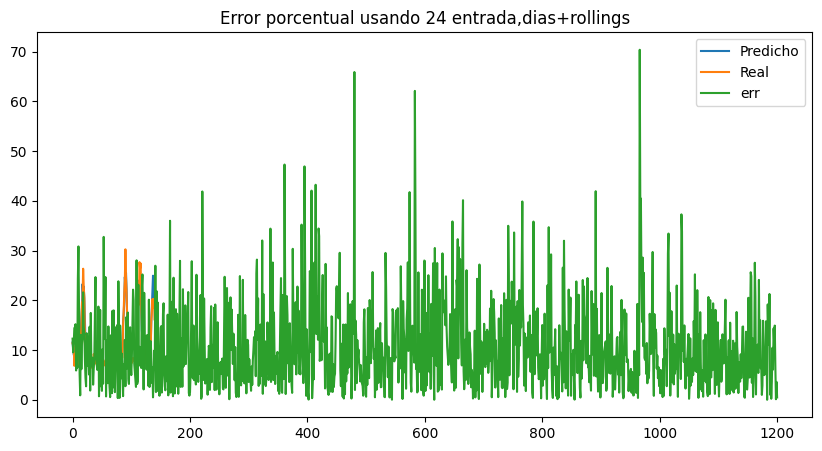

In [209]:
plt.figure(figsize=(10, 5))
plt.plot(ypred[200:350,0], label='Predicho')
plt.plot(ytest[200:350,0], label='Real')
plt.plot(error_percentual[00:350999,0], label='err')
#plt.plot(error_percentual_tft[200:350999,0], label='errtft')

plt.legend()
plt.title('Error porcentual usando 24 entrada,dias+rollings')
plt.show()

C:\Users\jorge\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: modelos\8\modelofinal\assets


INFO:tensorflow:Assets written to: modelos\8\modelofinal\assets


# BD

In [256]:
import sqlite3, json
from datetime import datetime
#para convertir a lista y guardar json
def to_list(x):
    if isinstance(x, np.ndarray):
        return x.tolist()
    return x

conn = sqlite3.connect("experimentos.db")
c = conn.cursor()

# Crear tabla si no existe
c.execute("""
CREATE TABLE IF NOT EXISTS experimentos (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    fecha TEXT,
    arquitectura TEXT,
    optimizer TEXT,
    metrics TEXT,
    hiperparametros TEXT,
    train_size INTEGER,
    val_size INTEGER,
    test_size INTEGER,
    train_desde TEXT,
    train_hasta TEXT,
    val_desde TEXT,
    val_hasta TEXT,
    test_desde TEXT,
    test_hasta TEXT,
    valor_pico REAL,
    cantidad_picos REAL,
    mejor_persistentes REAL,
    mejor_persistentes05 REAL,
    comentarios TEXT,
    parametros_extra TEXT
)
""")

# Ejemplo de datos de un experimento
config = json.dumps(model.get_config())
#optimizer = json.dumps(model.optimizer.get_config())

optimizer_json = json.dumps(
    model.optimizer.get_config(),
    default=lambda x: float(x) if isinstance(x, (np.float32, np.float64)) else x
)

loss = str(model.loss)
metrics = json.dumps(model.metrics_names)
metrics_json = json.dumps(metrics, default=lambda x: float(x) if isinstance(x, (np.float32, np.float64)) else x)

hiperparametros = json.dumps({"batch_size": BATCH_SIZE, "epochs": EPOCAS, "learning_rate": 0.001})
hiperparametros_json = json.dumps(hiperparametros, default=lambda x: float(x) if isinstance(x, (np.float32, np.float64)) else x)


c.execute("""
INSERT INTO experimentos (
    fecha, arquitectura, optimizer, metrics, hiperparametros, 
    train_size, val_size, test_size,
    train_desde,train_hasta,val_desde,val_hasta,test_desde,test_hasta,
    valor_pico,cantidad_picos, mejor_persistentes, mejor_persistentes05,
    comentarios, parametros_extra
) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ? )
""", (
    datetime.now().isoformat(),
    config,
    optimizer_json,
    metrics_json,
    hiperparametros_json,
    fin_train-inicio_train,   # train
    fin_val-inicio_val,    # validación
    fin_test-inicio_test,     # test
    str(FECHA_INICIO_TRAIN),
    str(FECHA_FIN_TRAIN),
    str(FECHA_INICIO_VAL),
    str(FECHA_FIN_VAL),
    str(FECHA_INICIO_TEST),
    str(FECHA_FIN_TEST),

    PICO_CONSIDERABLE,
    int(cantidad_picos),      # cantidad_picos
    porcentaje_mejora_lstm,    # mejor_persistentes (85%)
    porcentaje_mejora_lstm05,    # mejor_persistentes05 (73%)
    COMENTARIO,  # comentario libre
    json.dumps({"ventana entrada": ventana_entrada, "ventana salida": ventana_salida,
                "paciencia early": training_summary["early_stopping_patience"], 
                "tiempo train(m)": training_summary["total_time_m"], "mejor epoca": training_summary["best_epoch"],
                "umbral consideracion del dia": UMBRAL_CONSIDERACION_DIA, "dias usados": dias, "horas usadas": horas,
                "error prom modelo": to_list(error_prom_modelo), "error prom persistencia": to_list(error_prom_persist),
                "std modelo": to_list(error_std_modelo), "std persistencia": to_list(error_std_persist),
                "relativo modelo": to_list(error_rel_modelo), "relativo persistencia": to_list(error_rel_persistencia),
                "porcentaje mejora": to_list(porcentaje_mejora), "porcentaje mejora 05": to_list(porcentaje_mejora50)
                
                
                })
))

conn.commit()
id_modelo = c.lastrowid
conn.close()


def guardar_modelo_y_resultados(carpeta, modelo, scalers):
    # Guardar el modelo


    # Guardar los escaladores
    scalers_path = os.path.join(carpeta, 'scalers.pkl')
    with open(scalers_path, 'wb') as f:
        pickle.dump(scalers, f)


    return  scalers_path


# Guardar el modelo en formato recomendado (.keras)
save_dir = "modelos"
os.makedirs(save_dir, exist_ok=True)  # crea 'modelos' si no existe

# Carpeta específica para este modelo, usando el id
model_carpeta = os.path.join(save_dir, str(id_modelo))
os.makedirs(model_carpeta, exist_ok=True)

model.save(os.path.join(model_carpeta, f"{id_modelo}.keras"))

# Guardar en formato HDF5 (.h5) como alternativa
model.save(os.path.join(model_carpeta, f"{id_modelo}.h5"))
#model.save(os.path.join(model_carpeta, "modelofinal"))

guardar_modelo_y_resultados(model_carpeta,None,scalers)

C:\Users\jorge\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'modelos\\20\\scalers.pkl'

In [ ]:
print("Desvío estándar modelo por paso:", error_std_modelo)
print("Error relativo % modelo por paso:", error_rel_modelo)
print("")
print("Error promedio persistencia por paso:", error_prom_persist)
print("Desvío estándar persistencia por paso:", error_std_persist)
print("Error relativo % persistencia por paso:", error_rel_persistencia)
print("")
print("Porcentaje de mejora vs persistencia por paso:", porcentaje_mejora)
print("Porcentaje de mejora >50% vs persistencia por paso:", porcentaje_mejora50)

In [89]:
id_modelo

9

In [90]:
cantidad_picos

451

In [1]:
import sqlite3
import json

# Conectar a la BD
conn = sqlite3.connect("experimentos.db")
c = conn.cursor()

# Traer todo de la tabla
c.execute("SELECT * FROM experimentos")
rows = c.fetchall()

# Mostrar filas
for row in rows:
    print(row)

conn.close()

(1, '2025-09-20T20:00:15.160928', '{"name": "sequential", "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 24, 7], "dtype": "float32", "sparse": false, "ragged": false, "name": "lstm_input"}, "registered_name": null}, {"module": "keras.layers", "class_name": "LSTM", "config": {"name": "lstm", "trainable": true, "dtype": "float32", "batch_input_shape": [null, 24, 7], "return_sequences": false, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "time_major": false, "units": 32, "activation": "tanh", "recurrent_activation": "sigmoid", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": 47}, "registered_name": null}, "recurrent_initializer": {"module": "keras.initializers", "class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Ze

In [4]:
import sqlite3
import json

# Conectar a la BD
conn = sqlite3.connect("experimentos.db")
c = conn.cursor()

# Traer todo de la tabla
c.execute("SELECT id,comentarios,json_extract(parametros_extra, '$.\"ventana entrada\"') AS ventana_entrada, json_extract(parametros_extra, '$.\"ventana salida\"') AS ventana_salida, cantidad_picos, mejor_persistentes, mejor_persistentes05, valor_pico ,json_extract(parametros_extra, '$.\"error prom modelo\"') AS error_prom_modelo FROM experimentos")
rows = c.fetchall()

# Mostrar filas
for row in rows:
    print(row)

conn.close()

(1, 'solo dias habiles | promedio', 24, 1, 179.0, 95.53072625698324, 71.50837988826815, 3.0, None)
(2, 'solo dias habiles | promedio', 24, 1, 372.0, 95.16129032258065, 73.11827956989248, 3.0, None)
(3, 'solo dias habiles | max', 24, 1, 306.0, 91.50326797385621, 63.0718954248366, 3.0, None)
(4, 'media todos los dias', 24, 1, 165.0, 95.75757575757575, 76.36363636363637, 3.0, None)
(5, 'media todos los dias', 24, 1, 373.0, 95.71045576407506, 62.73458445040214, 3.0, None)
(6, 'media todos los dias', 24, 6, 1686.0, 81.85053380782918, 49.46619217081851, 3.0, None)
(7, 'media todos los dias', 168, 1, 281.0, 95.37366548042705, 76.15658362989323, 3.0, None)
(8, 'media todos los dias', 168, 1, 281.0, 95.01779359430606, 72.59786476868328, 3.0, None)
(9, 'media todos los dias', 24, 1, 451.0, 93.56984478935698, 54.32372505543237, 2.0, None)
(10, 'media todos los dias, 2 picos distintos (valor y valor*2)', 24, 1, 451.0, 92.23946784922394, 58.758314855875824, 2.0, None)
(11, 'minimo todos los dias', 

In [116]:
conn.close()

TypeError: list indices must be integers or slices, not str